In [2]:
import sys
import torch

seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree 
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


[09:22:47] WARNING: not removing hydrogen atom without neighbors
[09:22:47] WARNING: not removing hydrogen atom without neighbors
[09:22:47] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


## Data

In [3]:
from typing import Literal
lib: Literal["NIST", "MSDIAL", "NIST/MSDIAL"] = "NIST/MSDIAL"
lib= "MoNA"
print(f"Preparing {lib} library")

test_run = False # Default: False
if test_run:
    print("+++ This is a test run with a small subset of data points. Results are not representative. +++")

Preparing MoNA library


In [34]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }


#
# Load specified libraries and align metadata
#

def load_nist():
    library_name = "nist_msms_filteredall_07_2023"
    library_directory = f"{home}/data/metabolites/NIST17/msp/nist_msms/"  
    L = LibraryLoader()
    df = L.load_from_csv(library_directory + library_name + ".csv") 
    df["RETENTIONTIME"] = np.nan
    df["CCS"] = np.nan
    df["PPM_num"] = 50
    df["ppm_peak_tolerance"] = df["PPM_num"] * PPM
    df["lib"] = "NIST"
    df["origin"] = "NIST"
    
    return df

def load_msdial():
    library_name = "ms_dial_filtered_all_mid_08_2023"
    library_directory = f"{home}/data/metabolites/MS_DIAL/"
    L = LibraryLoader()
    df = L.load_from_csv(library_directory + library_name + ".csv")
    
    orbitrap_nametags = ["Orbitrap"]
    qtof_nametags = ["QTOF", "LC-ESI-QTOF", "ESI-QTOF"]
    df["Instrument_type"] = df["INSTRUMENTTYPE"].apply(lambda x: "HCD" if x in orbitrap_nametags else "Q-TOF" if x in qtof_nametags else x)
    df["Ionization"] = "ESI"
    df["original_RT"] = df["RETENTIONTIME"].astype(float)
    df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)
    df["CCS"] = df["CCS"].astype(float)
    df["PrecursorMZ"] = df["PRECURSORMZ"].astype(float)
    df["Precursor_type"] = df["PRECURSORTYPE"]
    df["Name"] = df["NAME"]
    df["PPM_num"] = 50
    df["ppm_peak_tolerance"] = df["PPM_num"] * PPM
    df["lib"] = "MSDIAL"
    
    # Filter out retention times using other phase types (e.g. HILIC) or of unknown/heterogeneous souces
    #df[df["origin"] == "MassBank High Quality Mass Spectral Database"]["RETENTIONTIME"] = np.nan
    #df[df["origin"] == "Fiehn Lab HILIC Library"]["RETENTIONTIME"] = np.nan
    bad_RT_libs = ["MassBank High Quality Mass Spectral Database", "Fiehn Lab HILIC Library"]
    potential_homogenous_RT_libs = ['BMDMS-NP']# , 'RIKEN Plant Specialized Metabolome Annotation (PlaSMA) Authentic Standard Library' 'BMDMS-NP' , "Global Natural Product Social Molecular Networking Library"]
    df["RETENTIONTIME"] = df.apply(lambda x: x["RETENTIONTIME"] if x["origin"] in potential_homogenous_RT_libs else np.nan, axis=1)
    
    return df


def load_mona():
    library_name = "nist_msms_filtered_min1_02_2025"
    library_directory = "../data/"
    L = LibraryLoader()
    df = L.load_from_csv(library_directory + library_name + ".csv")
    
    orbitrap_nametags = ["Orbitrap"]
    qtof_nametags = ["QTOF", "LC-ESI-QTOF", "ESI-QTOF"]
    df["Instrument_type"] = df["Instrument_type"].apply(lambda x: "HCD" if x in orbitrap_nametags else "Q-TOF" if x in qtof_nametags else x)
    df["RETENTIONTIME"] = np.nan
    df["CCS"] = np.nan
    df["PPM_num"] = 50
    df["ppm_peak_tolerance"] = df["PPM_num"] * PPM
    df["lib"] = "MoNA"
    df["origin"] = "MoNA"
    df["Ionization"] = "ESI"
   
    return df



if lib == "NIST":
    df = load_nist()    
elif lib == "MSDIAL":
    df = load_msdial()
elif lib == "NIST/MSDIAL":
    df = pd.concat([load_nist(), load_msdial()], ignore_index=True)
    #df.reset_index(inplace=True) # Avoid conflict from index overlap of the two dataframes
elif lib=="MoNA":
    df=load_mona()
    
 #Restore dictionary values
dict_columns = ["peaks"]
for col in dict_columns:
    df[col] = df[col].apply(ast.literal_eval)
    

df_org=df.copy()

In [35]:
#%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder
#
filter_spectra = True
CE_upper_limit = 100.0
weight_upper_limit = 1000.0


if test_run:
    df = df.iloc[5000:6000,:]
    #df = df.iloc[5000:20000,:]



df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

if filter_spectra:
    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))

df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

if filter_spectra:
    num_ori = df.shape[0]
    correct_energy = df["Metabolite"].apply(lambda x: x.metadata["collision_energy"] <= CE_upper_limit and x.metadata["collision_energy"] > 1) 
    df = df[correct_energy]
    correct_weight = df["Metabolite"].apply(lambda x: x.metadata["molecular_weight"] <= weight_upper_limit)
    df = df[correct_weight]    
    print(f"Filtering spectra ({num_ori}) down to {df.shape[0]}")
    print(df["Precursor_type"].value_counts())


Filtering spectra (32316) down to 31722
Precursor_type
[M+H]+    21560
[M-H]-    10162
Name: count, dtype: int64


## CASMI 


In [149]:

import pandas as pd
casmi16_path = f"../../CASMI16/casmi16_challenges_combined.csv"
#casmi16train_path = f"{home}/data/metabolites/CASMI_2016/casmi16_training_combined.csv"
#casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_challenges_combined.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
#df_cast = pd.read_csv(casmi16train_path, index_col=[0], low_memory=False)
#df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)
   # df_cast[col] = df_cast[col].apply(ast.literal_eval)

#df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)
#df_cas22 = df_cas22.reset_index()

In [150]:
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["CCS"] = [[]] * df_cas.shape[0]
### CHECK IF train test split is correct

iii = []
xxx = []
for i,d in df_cas.iterrows():
    m = d["Metabolite"]
    
    for x,D in df.iterrows():
        M = D["Metabolite"]
        if (m == M):
            iii += [i]
            xxx += [x]
            if D["CCS"]:
                df_cas.at[i, "CCS"] = df_cas.at[i, "CCS"] + [D["CCS"]] # Add CCS metadata

          
iii = np.unique(iii)  
print(f"Found {len(iii)} instances violating test/train split (CASMI 16 Challenge). Metabolite found in train/val set.")
print(f"Dropping {len(xxx)} spectra from training DataFrame.")
df.drop(xxx, inplace=True)

# Add CCS metadata
df_cas["CCS_std"] = df_cas["CCS"].apply(np.std)
df_cas["CCS"] = df_cas["CCS"].apply(np.mean)


Found 131 instances violating test/train split (CASMI 16 Challenge). Metabolite found in train/val set.
Dropping 578 spectra from training DataFrame.


/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
df_cast["Metabolite"] = df_cast["SMILES"].apply(Metabolite)
df_cast["CCS"] = [[]] * df_cast.shape[0]
### CHECK IF train test split is correct

iii = []
xxx = []
for i,d in df_cast.iterrows():
    m = d["Metabolite"]
    
    for x,D in df.iterrows():
        M = D["Metabolite"]
        if (m == M):
            iii += [i]
            xxx += [x]
            if D["CCS"]:
                df_cast.at[i, "CCS"] = df_cast.at[i, "CCS"] + [D["CCS"]] # Add CCS metadata

          
iii = np.unique(iii)  
print(f"Found {len(iii)} instances violating test/train split (CASMI 16 Training). Metabolite found in train/val set.")
print(f"Dropping {len(xxx)} spectra from training DataFrame.")
df.drop(xxx, inplace=True)

# Add CCS metadata
df_cast["CCS_std"] = df_cast["CCS"].apply(np.std)
df_cast["CCS"] = df_cast["CCS"].apply(np.mean)

In [ ]:
df_cas22_unique = df_cas22.drop_duplicates(subset='ChallengeName', keep='first')
df_cas22_unique.reset_index(inplace=True)
df_cas22_unique["Metabolite"] = df_cas22_unique["SMILES"].apply(Metabolite)
df_cas22_unique.shape

In [ ]:
### CHECK IF train test split is correct

iii = []
xxx = []

df_cas22_unique["CCS"] = [[]] * df_cas22_unique.shape[0]


for i,d in df_cas22_unique.iterrows():
    m = d["Metabolite"]
    
    for x,D in df.iterrows():
        M = D["Metabolite"]
        if (m == M):
            iii += [i]
            xxx += [x]
    
            if D["CCS"]:
                df_cas22_unique.at[i, "CCS"] = df_cas22_unique.at[i, "CCS"] + [D["CCS"]] # Add CCS metadata
            
iii = np.unique(iii)  
print(f"Found {len(iii)} instances violating test/train split (CASMI 22). Metabolite found in train/val set.")
print(f"Dropping {len(xxx)} spectra from training DataFrame.")
df.drop(xxx, inplace=True)

# Add CCS metadata
df_cas22_unique["CCS_std"] = df_cas22_unique["CCS"].apply(np.std)
df_cas22_unique["CCS"] = df_cas22_unique["CCS"].apply(np.mean)
df_cas22["CCS"] = df_cas22["ChallengeName"].apply(lambda x: df_cas22_unique[df_cas22_unique["ChallengeName"] == x]["CCS"].iloc[0])
df_cas22["CCS_std"] = df_cas22["ChallengeName"].apply(lambda x: df_cas22_unique[df_cas22_unique["ChallengeName"] == x]["CCS_std"].iloc[0])


In [ ]:
df_cas22_unique[~df_cas22_unique["CCS"].isna()]

# TODO add those to df_cas22

df_cas22["CCS"] = df_cas22["ChallengeName"].apply(lambda x: df_cas22_unique[df_cas22_unique["ChallengeName"] == x]["CCS"].iloc[0])
df_cas22["CCS_std"] = df_cas22["ChallengeName"].apply(lambda x: df_cas22_unique[df_cas22_unique["ChallengeName"] == x]["CCS_std"].iloc[0])

In [ ]:
# Save casmi with
save_df=False
if save_df:

    df_cas.to_csv(f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv")
    #df_cast.to_csv(f"{home}/data/metabolites/CASMI_2016/casmi16t_withCCS.csv")
    #df_cas22.to_csv(f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv")

    print(df_cas.head(3))
   #print(df_cas22.head(3))


## MoNA cont

In [36]:
print("Assigning unique metabolite identifiers.")

metabolite_id_map = {}

for metabolite in df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.set_id(id)
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite

df["group_id"] = df["Metabolite"].apply(lambda x: x.get_id())
df["num_per_group"] = df["group_id"].map(df["group_id"].value_counts())

for i, data in df.iterrows():
    data["Metabolite"].set_loss_weight(1.0 / data["num_per_group"])
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

Assigning unique metabolite identifiers.
Found 5273 unique molecular structures.


In [37]:
df.groupby("lib").group_id.unique().apply(len)


lib
MoNA    5273
Name: group_id, dtype: int64

In [38]:
df.shape

(31722, 45)

In [39]:
df["loss_weight"] = df["Metabolite"].apply(lambda x: x.loss_weight)

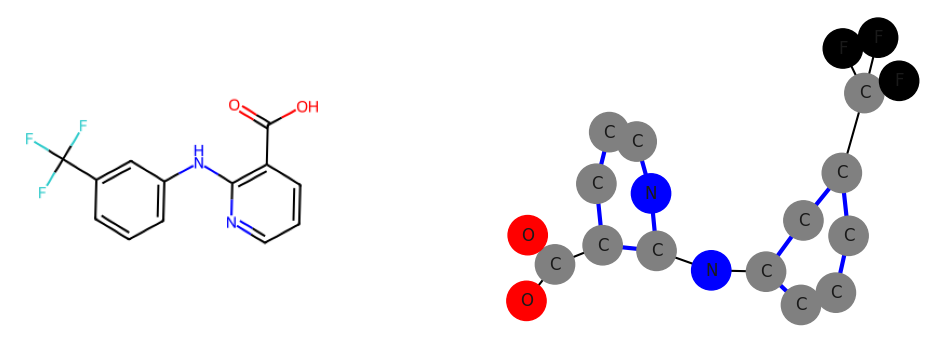

In [10]:
from fiora.MOL.mol_graph import draw_graph
from fiora.visualization.define_colors import define_figure_style, color_palette, bluepink, bluepink_grad, bluepink_grad8, tri_palette
from fiora.visualization.define_colors import *
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 6)

magma_palette = define_figure_style(style="magma-white", palette_steps=8)

if not test_run:
    EXAMPLE_ID = 321 if (lib == "MoNA") else 7607 if lib == "MSDIAL" else 0
    example = df.loc[EXAMPLE_ID]

    fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)
    set_light_theme()

    img = example["Metabolite"].draw(ax=axs[0])
    draw_graph(example["Metabolite"].Graph, ax=axs[1])

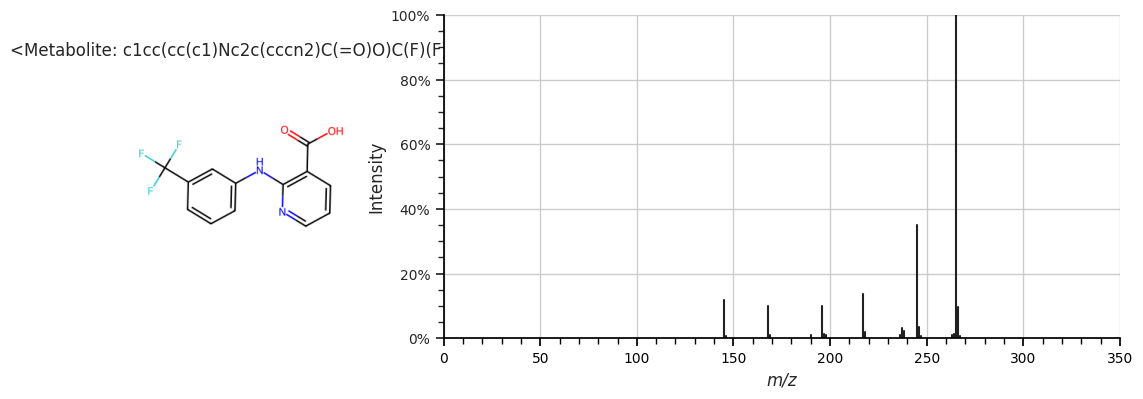

In [11]:
if not test_run:
    fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)

    img = example["Metabolite"].draw(ax= axs[0])

    axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    axs[0].set_title(str(example["Metabolite"]))
    axs[0].imshow(img)
    axs[0].axis("off")
    sv.plot_spectrum(example, ax=axs[1])

In [40]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)


In [114]:
example = df.iloc[10]
example["Metabolite"].match_stats
#raise KeyboardInterrupt()

{'counts': 106.49002075195312,
 'ms_all_counts': 152.989158,
 'coverage': 0.6960625324309133,
 'coverage_wo_prec': 0.042421429919919505,
 'precursor_prob': 0.9390551273619309,
 'precursor_raw_prob': 0.6536410900437795,
 'num_peaks': 8,
 'num_peak_matches': 3,
 'percent_peak_matches': 0.375,
 'num_peaks_filtered': 6,
 'num_peak_matches_filtered': 2,
 'percent_peak_matches_filtered': 0.25,
 'num_non_precursor_matches': 2,
 'num_peak_match_conflicts': 0,
 'num_fragment_conflicts': 0,
 'rel_fragment_conflicts': 0.0,
 'ms_num_all_peaks': 8}

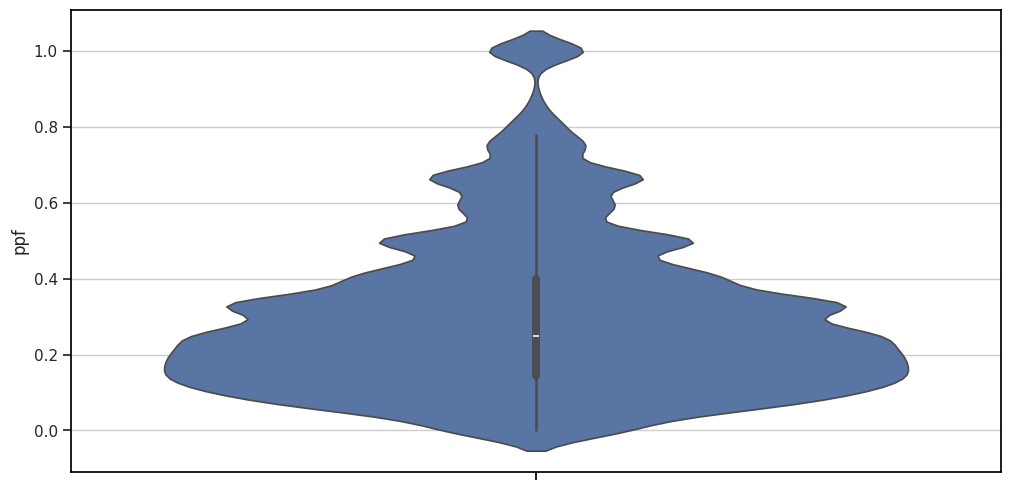

In [41]:
df["np"] = df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"])
df["npf"] = df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches_filtered"])
df["ppf"] = df["Metabolite"].apply(lambda x: x.match_stats["percent_peak_matches_filtered"])

sns.violinplot(data=df, y="ppf")
plt.show()

In [116]:
sum((df["ppf"] > 0.5) & (df["npf"] < 5) & (df["npf"] > 2))

2333

In [117]:
df["np"].value_counts().head(10)


np
2    6284
3    5969
1    5783
4    4356
5    2955
6    1982
7    1293
0     901
8     848
9     563
Name: count, dtype: int64

In [118]:
df["npf"].value_counts().head(10)

npf
2    7907
1    7392
3    6513
4    4086
5    2328
6    1287
0     901
7     689
8     299
9     169
Name: count, dtype: int64

In [119]:
example.Metabolite.peak_matches

{126.0657: {'intensity': 0.881548,
  'fragments': [<Fragment Object> :: COc1ccc(N)nn1],
  'ion_modes': [('[M+H]+', 126.06618829608999)],
  'relative_intensity': 0.00827822183034825,
  'edges': [(8, 9)]},
 156.0104: {'intensity': 5.608471,
  'fragments': [<Fragment Object> :: Nc1ccc([SH](=O)=O)cc1],
  'ion_modes': [('[M-H]+', 156.01137585209)],
  'relative_intensity': 0.0526666353585682,
  'edges': [(8, 9)]},
 281.0702: {'intensity': 100.0,
  'fragments': [<Fragment Object> :: COc1ccc(NS(=O)(=O)c2ccc(N)cc2)nn1],
  'ion_modes': [('[M+H]+', 281.07028769609)],
  'relative_intensity': 0.9390551428110835,
  'edges': [None]}}

In [120]:
#df = ORI_DF.copy(deep=True)
ORI_DF = df.copy(deep=True)

In [121]:
df = ORI_DF.copy(deep=True)

In [42]:
from fiora.MOL.constants import ADDUCT_WEIGHTS, PPM

df["Precursor_offset"] = df["PrecursorMZ"] - df.apply(lambda x: x["Metabolite"].ExactMolWeight + ADDUCT_WEIGHTS[x["Precursor_type"]], axis=1)
df["Precursor_abs_error"] = abs(df["Precursor_offset"])
df["Precursor_rel_error"] = df["Precursor_abs_error"] / df["PrecursorMZ"]
df["Precursor_ppm_error"] = df["Precursor_abs_error"] / (df["PrecursorMZ"] * PPM)
print((df["Precursor_ppm_error"] > df["PPM_num"]).sum(), "found with misaligned precursor. Removing these.")

df = df[df["Precursor_ppm_error"] <= df["PPM_num"]]

930 found with misaligned precursor. Removing these.


<Axes: xlabel='coverage', ylabel='Density'>

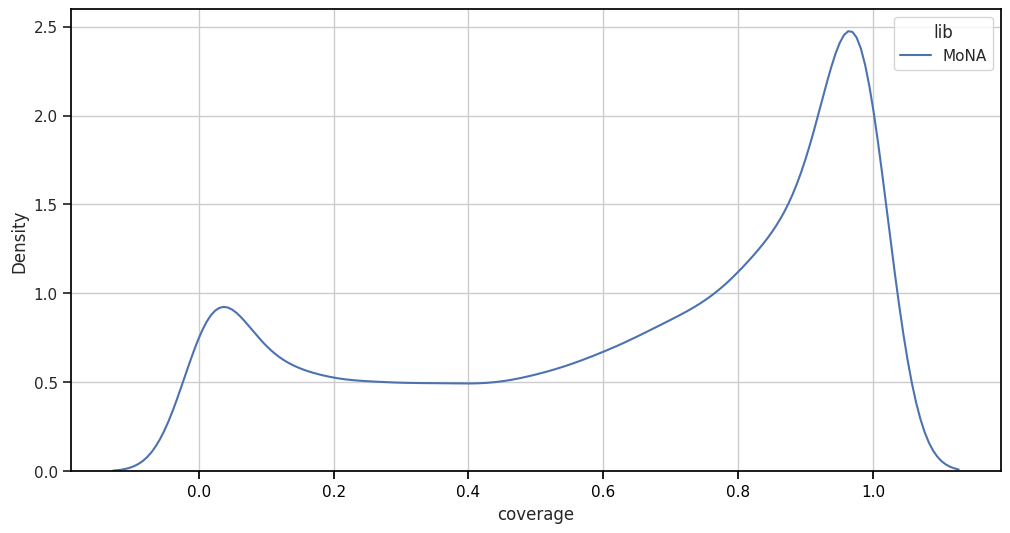

In [43]:
df["coverage"] = df["Metabolite"].apply(lambda x: x.match_stats["coverage"])
sns.kdeplot(data=df, x="coverage", hue="lib")#, multiple="dodge")

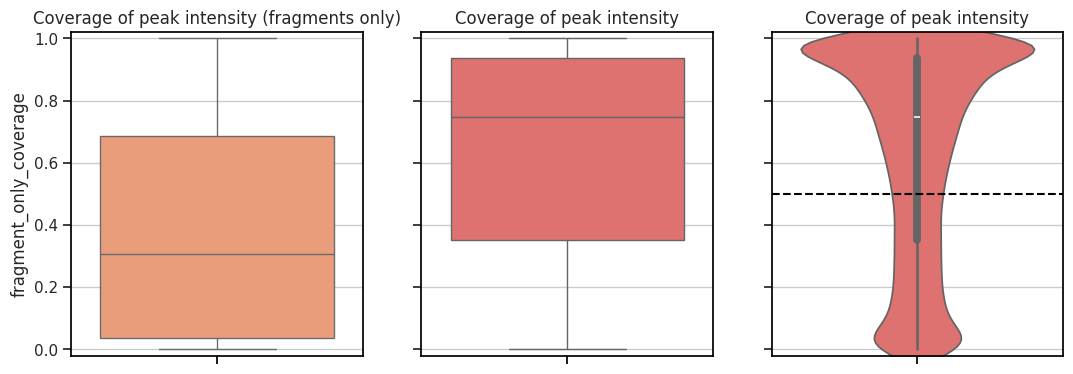

Filtering out 37759 that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible


In [44]:
# TODO Implement conflict solver

coverage_tracker = {"counts": [], "all": [], "coverage": [], "fragment_only_coverage": [], "Precursor_type": []}

drop_index = []
for i,d in df.iterrows():
    M = d["Metabolite"]
    
    
    coverage_tracker["counts"] += [M.match_stats["counts"]]
    coverage_tracker["all"] += [M.match_stats["ms_all_counts"]]
    coverage_tracker["fragment_only_coverage"] += [M.match_stats["coverage_wo_prec"]]
    coverage_tracker["coverage"] += [M.match_stats["coverage"]]
    coverage_tracker["Precursor_type"] += [M.metadata["precursor_mode"]]
    
    
    #
    # IMPORTANT: FILTER AND CLEAN DATA
    #
    
    
    min_coverage = 0.5
    if M.match_stats["coverage"] < min_coverage: # Filter if total coverage is too low
        drop_index.append(i)
    
    min_peaks = 2
    if M.match_stats["num_peak_matches_filtered"] < min_peaks:
        drop_index.append(i)

    # Either condition is enough to keep the spectrum
    desired_peaks = 5
    desired_peak_percentage = 0.5
    extremly_high_coverage = 0.8
    if (M.match_stats["num_peak_matches_filtered"] < desired_peaks) & (M.match_stats["percent_peak_matches_filtered"] < desired_peak_percentage) & (M.match_stats["coverage"] < extremly_high_coverage):
        drop_index.append(i)

        #if M.match_stats["num_non_precursor_matches"] < 1:
        #    drop_index.append(i)
    # max_conflicts_rel = 0.75
    # if M.match_stats["rel_fragment_conflicts"] > max_conflicts_rel: 
    #     drop_index.append(i)
    
    max_precursor = 0.9
    if M.match_stats["precursor_prob"] > max_precursor: # Filter if fragment coverage is too low (intensity wise)
       drop_index.append(i)
    
    # if d["lib"] == "MSDIAL":
    #     if d["INSTRUMENTTYPE"] == "Orbitrap": # and M.match_stats["precursor_prob"] > 0.95:
    #         drop_index.append(i)
    
    
# filter low res instruments TODO update to low quality spectra
low_quality_tags = ["IT/ion trap", "QqQ", "LC-ESI-QQ", "Flow-injection QqQ/MS", "LC-APPI-QQ", "LC-ESI-IT", "LC-ESI-QIT", "QIT"] #What about ESI-ITTOF? GC-APCI-QTOF?
low_res_machines = df["Metabolite"].apply(lambda x: x.metadata["instrument"] in low_quality_tags)
drop_index += list(df[low_res_machines].index)

fig, axs = plt.subplots(1, 3, figsize=(12.8, 4.2), sharey=True)

plt.ylim([-.02,1.02])
sns.boxplot(ax=axs[0], data=coverage_tracker, y="fragment_only_coverage", color=magma_palette[1])
sns.boxplot(ax=axs[1], data=coverage_tracker, y="coverage", color=magma_palette[2])
sns.violinplot(ax=axs[2], data=coverage_tracker, y="coverage", color=magma_palette[2])
axs[0].set_title("Coverage of peak intensity (fragments only)")
axs[1].set_title("Coverage of peak intensity")
axs[2].set_title("Coverage of peak intensity")
axs[2].axhline(y=min_coverage, color='black', linestyle='--', label='Horizontal Line')
plt.show()

print(f"Filtering out {len(drop_index)} that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible")
df.drop(drop_index, inplace=True)

Train and validate on 3031 unique structures


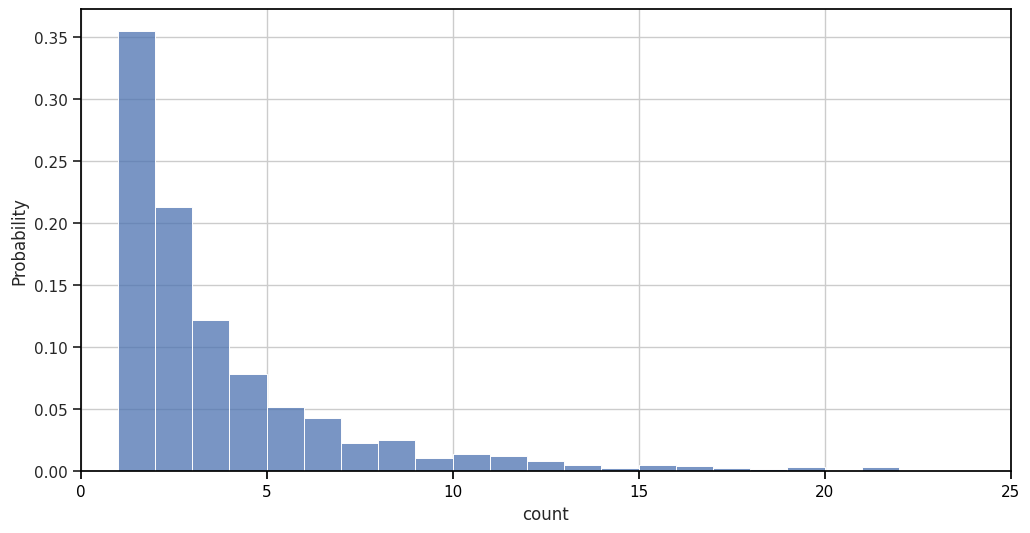

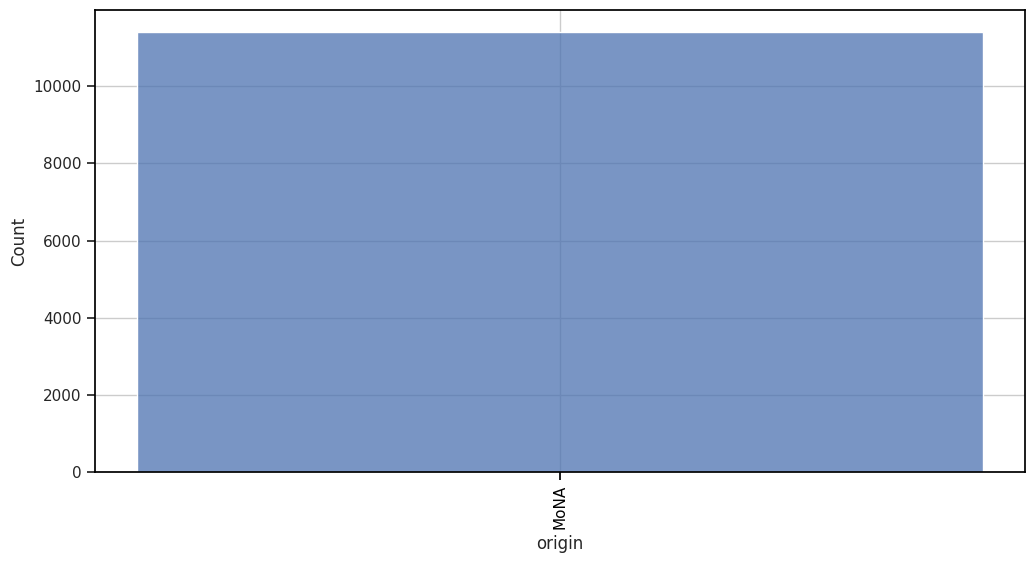

In [22]:
def custom_sample(group):
    sample_size = 20
    x_origin = group[group['lib'] == 'NIST']
    y_origin = group[group['lib'] == 'MSDIAL']
    
    if len(x_origin) >= sample_size:
        return x_origin.sample(n=sample_size, replace=False)
    elif len(y_origin) > 0:
        y_sample_size = min(len(y_origin), sample_size - len(x_origin))
        return pd.concat([x_origin, y_origin.sample(n=y_sample_size, replace=False)])
    else:
        return(x_origin)

#TURNED OFF
#df = df.groupby('group_id', group_keys=False).apply(custom_sample)
## df = df.groupby('group_id').apply(lambda group: group.sample(n=10, replace=True) if len(group) >= 10 else group)

#df = df.reset_index(drop=True)

num_structures = len(df["group_id"].unique())
print(f"Train and validate on {num_structures} unique structures")
sns.histplot(df["group_id"].value_counts(), stat="probability", binwidth=1)
plt.xlim([0, 25])
plt.show()

sns.histplot(df, x="origin", stat="count")
plt.xticks(rotation=90)
plt.show()

In [17]:
df.groupby("lib").group_id.unique().apply(len)

lib
MoNA    3031
Name: group_id, dtype: int64

## Model Training and Testing

In [18]:
import torch
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
 dev = "cuda:0"
else: 
 dev = "cpu" 
 
print(f"Running on device: {dev}")

Running on device: cuda:0


##### Load Data

In [19]:
#df.shape
DF_BACKUP = df.copy(deep=True)



In [24]:
# df = DF_BACKUP.copy(deep=True)
# print(df.shape)

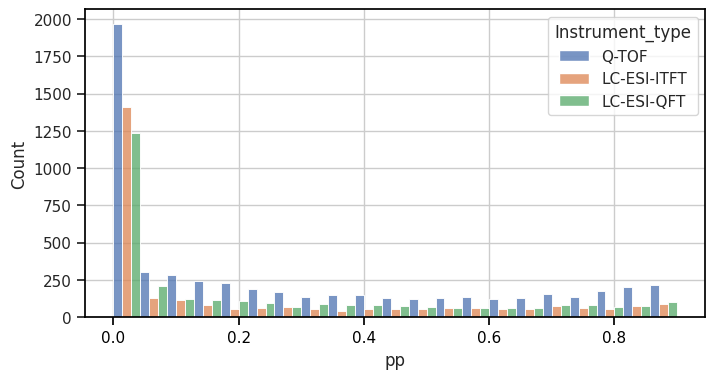

In [20]:
df["pp"] = df["Metabolite"].apply(lambda x: x.match_stats["precursor_prob"])
top_instrumenttypes = df['Instrument_type'].value_counts().head(3).index
f,a = plt.subplots(1,1, figsize=(8, 4))
sns.histplot(data=df[df['Instrument_type'].isin(top_instrumenttypes)], x="pp", hue="Instrument_type", multiple="dodge")
plt.show()

In [21]:
geo_data = df["Metabolite"].apply(lambda x: x.as_geometric_data().to(dev)).values
print(f"Prepared training/validation with {len(geo_data)} data points")

Prepared training/validation with 11406 data points


In [24]:
# for i, batch in enumerate(geo_data):
#     print(batch)
#     break



##### Prepare Model

In [25]:
model_params = {
    'gnn_type': 'RGCNConv',
    'depth': 6,
    'hidden_dimension': 300,
    'dense_layers': 2,
    'embedding_aggregation': 'concat',
    'embedding_dimension': 300,
    'input_dropout': 0.2,
    'latent_dropout': 0.1,
    'node_feature_layout': node_encoder.feature_numbers,
    'edge_feature_layout': bond_encoder.feature_numbers,    
    'static_feature_dimension': geo_data[0]["static_edge_features"].shape[1],
    'static_rt_feature_dimension': geo_data[0]["static_rt_features"].shape[1],
    'output_dimension': len(DEFAULT_MODES) * 2, # per edge 
}
training_params = {
    'epochs': 200 if not test_run else 20, #180,
    'batch_size': 256, #128,
    'train_val_split': 0.90,
    'learning_rate': 0.0004,#0.001,
    'with_RT': True, # TODO CHANGED
    'with_CCS': True
}

In [26]:
from fiora.GNN.GNNModules import GNNCompiler
from fiora.GNN.Losses import WeightedMSELoss, WeightedMSEMetric
model = GNNCompiler(model_params).to(dev)


##### Begin Training

* Sample compound (group) IDs for Training/Validaion/Test splits from a fixed seed and save them in the DataFrame
* Instatiate Trainer and Optimizer classes
* Cal training function

In [27]:
from sklearn.model_selection import train_test_split

def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=seed):
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys

# Make sure that the example is in the test split
if not test_run:
    ex_smiles = "CC(NC(=O)CC1=CNC2=C1C=CC=C2)C(O)=O"
    ex_metabolite = Metabolite(ex_smiles)
    ex_compound_id = df[df["Metabolite"] == ex_metabolite]["group_id"].iloc[0]

group_ids = df["group_id"].astype(int)
keys = np.unique(group_ids)
example_not_in_test_split = True

for i in range(100):
    train, val, test = train_val_test_split(keys, rseed=seed + i)
    if test_run or (ex_compound_id in test):
        print(f"Seed {seed + i} used to sample slits, such that the example Metabolite is in the test set.")
        break
df["dataset"] = df["group_id"].apply(lambda x: 'train' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')


Seed 49 used to sample slits, such that the example Metabolite is in the test set.


In [31]:
df.dataset.value_counts()

dataset
training      8932
test          1361
validation    1113
Name: count, dtype: int64

In [32]:
y_label = 'compiled_probsALL'
train_keys, val_keys = df[df["dataset"] == "train"]["group_id"].unique(), df[df["dataset"] == "validation"]["group_id"].unique()

trainer = Trainer(geo_data, y_tag=y_label, problem_type="regression", metric_dict={"mse": WeightedMSEMetric}, train_keys=train_keys, val_keys=val_keys, split_by_group=True, seed=seed, device=dev)
optimizer = torch.optim.Adam(model.parameters(), lr=training_params["learning_rate"])
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)    
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 8, factor=0.5, mode = 'min', verbose  = True)

loss_fn = WeightedMSELoss()
#loss_fn = torch.nn.MSELoss()

Using pre-arranged train/validation set


/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [33]:
tag = "b1"
checkpoints = trainer.train(model, optimizer, loss_fn, scheduler=scheduler, batch_size=training_params['batch_size'], epochs=training_params["epochs"], val_every_n_epochs=1, with_CCS=training_params["with_CCS"], with_RT=training_params["with_RT"], masked_validation=False, tag=tag) #, mask_name="compiled_validation_maskALL")

ValueError: num_samples should be a positive integer value, but got num_samples=0

##### Evaluation

In [140]:
from_checkpoint = True

if from_checkpoint:
    print(f"Loading model from checkpoint {checkpoints}.")
    end_model = GNNCompiler(model_params).to(dev)
    end_model = end_model.load_state_dict(model.state_dict())
    model = model.load(checkpoints["file"]).to(dev)
    

Loading model from checkpoint {'epoch': 69, 'val_loss': 0.00022627455473411828, 'file': '../../checkpoint_b1.best.pt'}.


In [30]:
df["dataset"] = df["group_id"].apply(lambda x: "training" if trainer.is_group_in_training_set(x) else "validation" if trainer.is_group_in_validation_set(x) else "test") 
df.dataset.value_counts()

dataset
training      8932
test          1361
validation    1113
Name: count, dtype: int64

In [141]:
from fiora.MS.SimulationFramework import SimulationFramework

df["dataset"] = df["group_id"].apply(lambda x: "training" if trainer.is_group_in_training_set(x) else "validation" if trainer.is_group_in_validation_set(x) else "test") 

fiora = SimulationFramework(model, dev=dev, with_RT=training_params["with_RT"], with_CCS=training_params["with_CCS"])
df = fiora.simulate_all(df, model)


/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/fiora/MS/spectral_scores.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec, vec_other) / (np.linalg.norm(vec) * np.linalg.norm(vec_other))
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/fiora/MS/spectral_scores.py:26: RuntimeWarning: invalid value encountered in divide
  vec = vec / np.linalg.norm(vec)


Indole-3-acetyl-L-alanine (112881): cosine 0.95


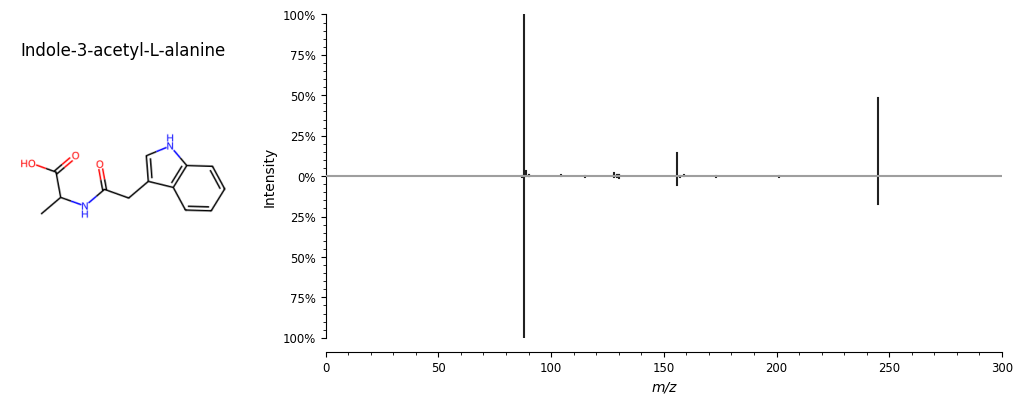

In [142]:
reset_matplotlib()
for i, data in df[df["Metabolite"] == ex_metabolite].iterrows():
    cosine = data["spectral_sqrt_cosine"]
    name = data["Name"]
    print(f"{name} ({i}): cosine {cosine:0.2}")
    fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])

    #axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
    axs[0].set_title(data["Name"])
    #axs[0].imshow(img)
    #axs[0].axis("off")
    #sv.plot_spectrum(example, ax=axs[1])
    ax = sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, ax=axs[1], highlight_matches=False)
    plt.show()


In [143]:
df[["cosine_similarity", "kl_div", "spectral_cosine", "spectral_sqrt_cosine", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_refl_bias"]] = df[["cosine_similarity", "kl_div", "spectral_cosine", "spectral_sqrt_cosine", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_refl_bias"]].astype(float)
#df["is_peptide"] = df["Notes"].apply(lambda x: "Peptide" in x) if lib == "NIST" else False

df_train = df[df["dataset"] == "training"]
df_val = df[df["dataset"]=="validation"]
df_val["library"] = "Validation"

for key in example["Metabolite"].match_stats.keys():
    df_val[key] = df["Metabolite"].apply(lambda x: x.match_stats[key])

df_val["ring_proportion"] = df["Metabolite"].apply(lambda x: (getattr(x, "is_edge_in_ring").sum() / getattr(x, "is_edge_in_ring").shape[0]).tolist())


/tmp/ipykernel_9026/2059735888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["library"] = "Validation"
/tmp/ipykernel_9026/2059735888.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[key] = df["Metabolite"].apply(lambda x: x.match_stats[key])
/tmp/ipykernel_9026/2059735888.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

/tmp/ipykernel_9026/2370285261.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axs[0], data=df, y="spectral_cosine", x="dataset", palette=bluepink)
/tmp/ipykernel_9026/2370285261.py:3: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=axs[0], data=df, y="spectral_cosine", x="dataset", palette=bluepink)
/tmp/ipykernel_9026/2370285261.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axs[1], data=df, y="spectral_sqrt_cosine", x="dataset", palette=bluepink)
/tmp/ipykernel_9026/2370285261.py:4: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=axs[1], data=df, y

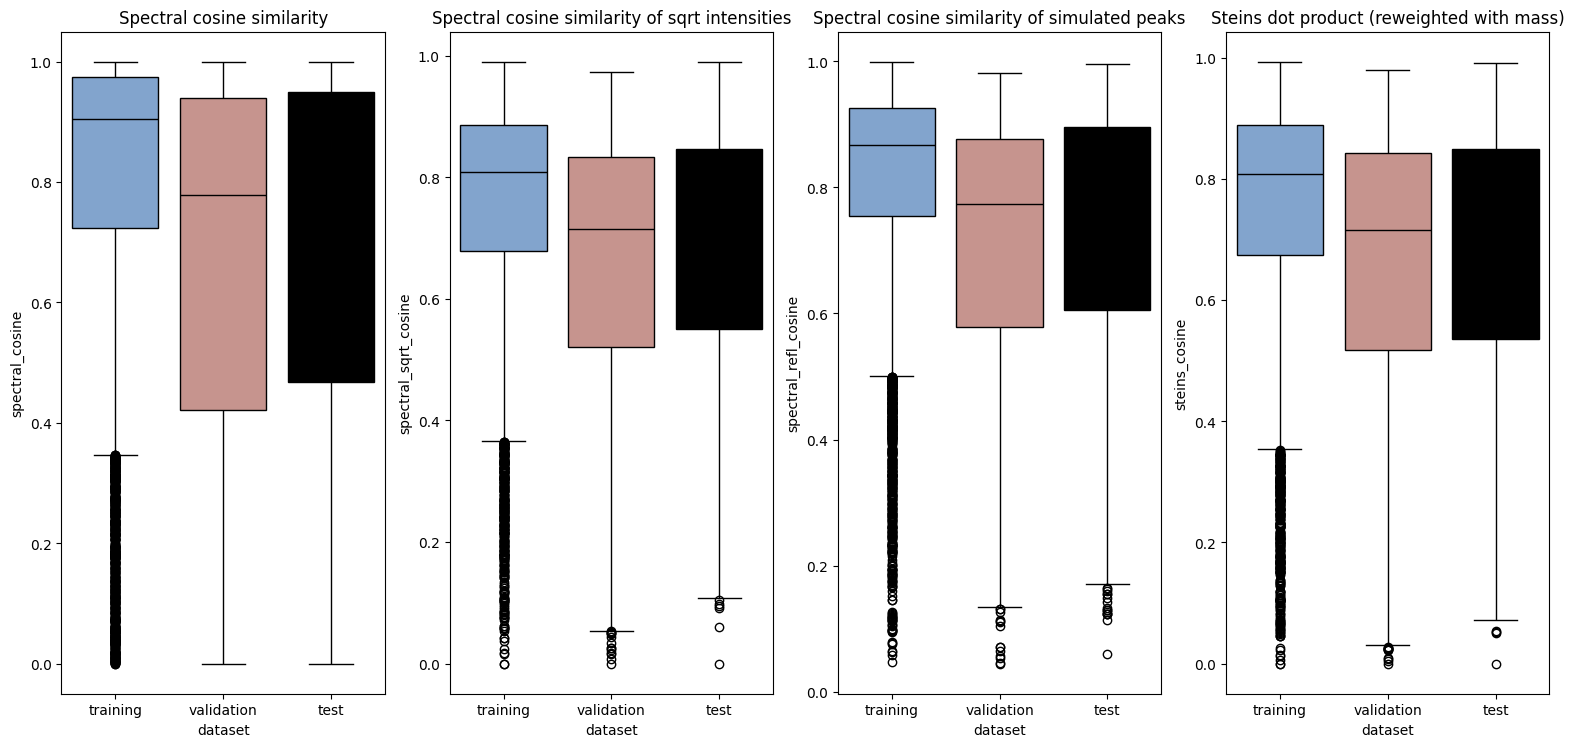

In [144]:
fig, axs = plt.subplots(1, 4, figsize=(19.2, 8.6), sharey=False)

sns.boxplot(ax=axs[0], data=df, y="spectral_cosine", x="dataset", palette=bluepink)
sns.boxplot(ax=axs[1], data=df, y="spectral_sqrt_cosine", x="dataset", palette=bluepink)
sns.boxplot(ax=axs[2], data=df, y="spectral_refl_cosine", x="dataset", palette=bluepink)
sns.boxplot(ax=axs[3], data=df, y="steins_cosine", x="dataset", palette=bluepink)
axs[0].set_title("Spectral cosine similarity")
axs[1].set_title("Spectral cosine similarity of sqrt intensities")
axs[2].set_title("Spectral cosine similarity of simulated peaks")
axs[3].set_title("Steins dot product (reweighted with mass)")
plt.show()

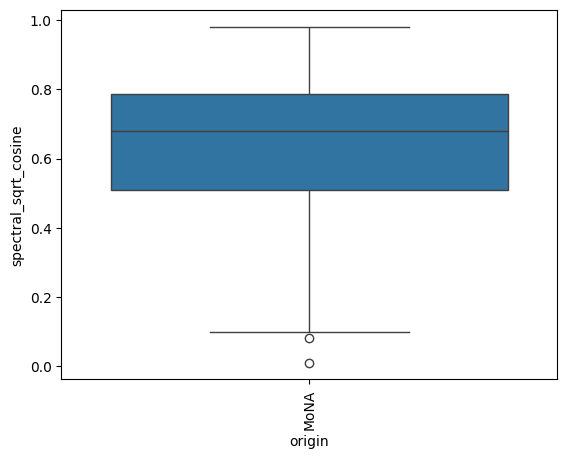

In [41]:
sns.boxplot(data=df_val, x="origin", y="spectral_sqrt_cosine")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# from fiora.MOL.collision_energy import NCE_to_eV
# # Test molecule: Phacidin (from mass bank)

# s = "CCCCCCCCC(=O)C1=C(OC(=CC1=O)C=O)OC"
# peaks = {"mz":  [57.071,  67.0553, 71.0866,  81.0709, 123.1168, 127.039, 141.1274, 155.0339, 169.0495, 197.0444, 267.1591, 295.154],
#          "intensity": [249, 91, 457, 216, 132, 129, 388, 35, 100, 110, 999, 676]
#          }#{"mz":  [71.0866, 141.1274, 267.1591, 295.154],
#          #"intensities": [39, 118, 160, 999]}
# Phacidin = Metabolite(s)
# Phacidin.create_molecular_structure_graph()
# Phacidin.compute_graph_attributes(node_encoder, bond_encoder)
# Phacidin.fragment_MOL()
# Phacidin.match_fragments_to_peaks(peaks["mz"], peaks["intensity"], tolerance=100 * PPM)
# meta = {"collision_energy":  NCE_to_eV(20, Phacidin.ExactMolWeight + 1), "instrument": "HCD", "name": "Phacidin", 'precursor_mode': "[M+H]+"} #NCE_to_eV(100, Phacidin.ExactMolWeight + 1)
# Phacidin.add_metadata(meta, setup_encoder, rt_encoder)
# #Phacidin.compiled_forward_mask = torch.cat([Phacidin.edge_forward_direction.squeeze(), torch.tensor([True, False], dtype=bool)], dim=-1)


# fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
# img = Phacidin.draw(ax= axs[0])

# axs[0].grid(False)
# axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
# axs[0].set_title("Phacidin")
# axs[0].imshow(img)
# axs[0].axis("off")
# #sv.plot_spectrum(example, ax=axs[1])
# ax = sv.annotate_and_plot({"peaks": peaks}, Phacidin.peak_matches.keys(), ppm_tolerance=100 * PPM, ax=axs[1])
# plt.show()
# print(f'{len(Phacidin.peak_matches)} matching fragments identified: {metabolite.peak_matches}')
# print(f'Conflicts: {Phacidin.match_stats["num_peak_match_conflicts"]}')
# print(f'Coverage: {Phacidin.match_stats["coverage"] * 100}% of peak intensities')
# print(Phacidin.edge_intensities)

In [ ]:
# Phacidin.compiled_probsALL_pred = fiora.predict_metabolite_property(metabolite, model=model, as_batch=True)
# stats = fiora.simulate_and_score(Phacidin, model=model, base_attr_name="compiled_probsALL", query_peaks=peaks, as_batch=True)


In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
# img = Phacidin.draw(ax= axs[0])

# axs[0].grid(False)
# axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
# axs[0].set_title("Phacidin")
# axs[0].imshow(img)
# axs[0].axis("off")
# #sv.plot_spectrum(example, ax=axs[1])
# ax = sv.plot_spectrum({"peaks": peaks}, {"peaks": stats["sim_peaks"]}, ax=axs[1])
# plt.show()

# if any(df_val["Name"] == "Phacidin"):
#     print("Phacidin is in the validation set" )
# if any(df_train["Name"] == "Phacidin"):
#     print("Phacidin is in the training set" )
# cos = stats["spectral_sqrt_cosine"]
# print(f"Spectral sqrt cosine: {cos}")


In [ ]:
# new_peaks = {"mz": [], "intensity": []}

# for i, mz in enumerate(stats["sim_peaks"]["mz"]):
#     if stats["sim_peaks"]["intensity"][i] > 0.02:
#         new_peaks["mz"].append(mz)
#         new_peaks["intensity"].append(stats["sim_peaks"]["intensity"][i])

#### Some statistics

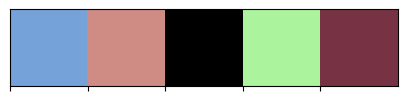

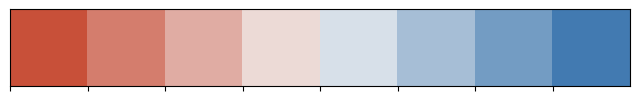

In [46]:
#from fiora.visualization.define_colors import bluepink_grad8

sns.palplot(bluepink)
plt.show()
sns.palplot(bluepink_grad8)
plt.show()


In [145]:
print("Stats at first glance (training and validation)")
keys = ["cosine_similarity", "kl_div", "spectral_cosine", "spectral_sqrt_cosine", "spectral_refl_cosine"]

for key in keys:
    blue = PRINT_COL["blue"]
    end = PRINT_COL["end"]
    print(f"Median {key}:  \t{df_train[key].median():.2f} {blue} {df_val[key].median():.2f} {end}")

Stats at first glance (training and validation)
Median cosine_similarity:  	0.92  0.79 
Median kl_div:  	1.01  1.73 
Median spectral_cosine:  	0.90  0.78 
Median spectral_sqrt_cosine:  	0.81  0.72 
Median spectral_refl_cosine:  	0.87  0.77 


In [48]:
# fig, axs = plt.subplots(1, 2, figsize=(12.8, 8.6), sharey=False)

# sns.boxplot(ax=axs[0], data=df, y="cosine_similarity", x="dataset", palette=bluepink)
# sns.boxplot(ax=axs[1], data=df, y="kl_div", x="dataset", palette=bluepink)
# axs[0].set_title("Cosine")
# axs[1].set_title("KL divergence")
# plt.show()

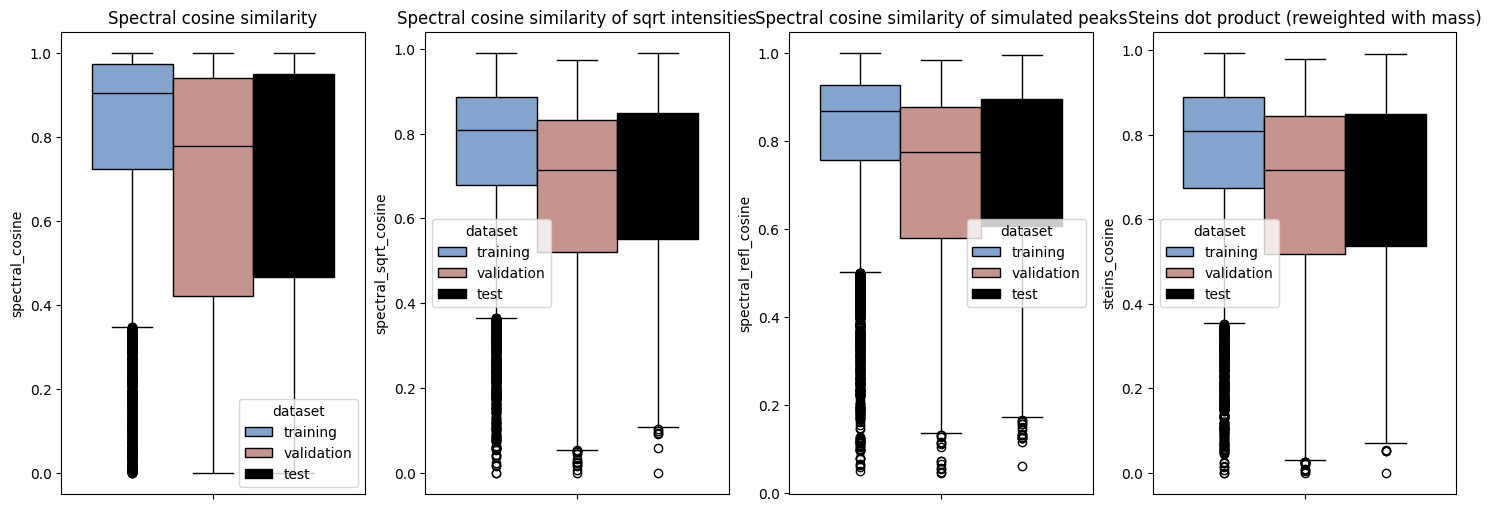

In [146]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=False)

sns.boxplot(ax=axs[0], data=df, y="spectral_cosine", hue="dataset", palette=bluepink[:3])
sns.boxplot(ax=axs[1], data=df, y="spectral_sqrt_cosine", hue="dataset", palette=bluepink[:3])
sns.boxplot(ax=axs[2], data=df, y="spectral_refl_cosine", hue="dataset", palette=bluepink[:3])
sns.boxplot(ax=axs[3], data=df, y="steins_cosine", hue="dataset", palette=bluepink[:3])
axs[0].set_title("Spectral cosine similarity")
axs[1].set_title("Spectral cosine similarity of sqrt intensities")
axs[2].set_title("Spectral cosine similarity of simulated peaks")
axs[3].set_title("Steins dot product (reweighted with mass)")
plt.show()

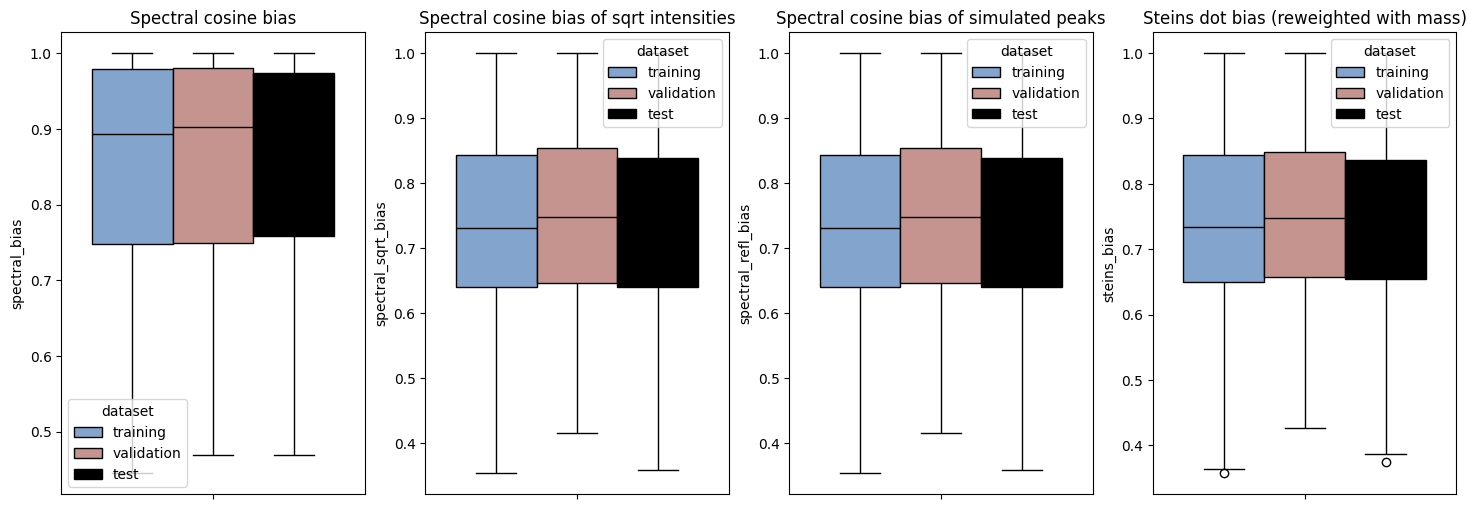

In [50]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=False)

sns.boxplot(ax=axs[0], data=df, y="spectral_bias", hue="dataset", palette=bluepink[:3])
sns.boxplot(ax=axs[1], data=df, y="spectral_sqrt_bias", hue="dataset", palette=bluepink[:3])
sns.boxplot(ax=axs[2], data=df, y="spectral_refl_bias", hue="dataset", palette=bluepink[:3])
sns.boxplot(ax=axs[3], data=df, y="steins_bias", hue="dataset", palette=bluepink[:3])
axs[0].set_title("Spectral cosine bias")
axs[1].set_title("Spectral cosine bias of sqrt intensities")
axs[2].set_title("Spectral cosine bias of simulated peaks")
axs[3].set_title("Steins dot bias (reweighted with mass)")
plt.show()

/tmp/ipykernel_6581/3378000538.py:3: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.boxplot(ax=ax, data=df_val, y="spectral_cosine", hue="Instrument_type", palette=bluepink_grad8)


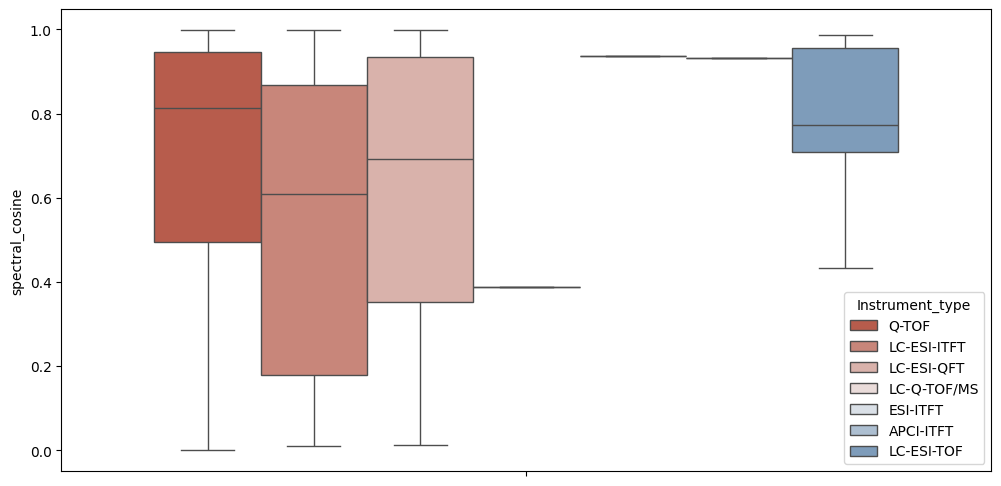

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=False)

sns.boxplot(ax=ax, data=df_val, y="spectral_cosine", hue="Instrument_type", palette=bluepink_grad8)
axs[0].set_title("Cosine")
plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12.8, 8.6), sharey=False)

# sns.boxplot(ax=ax, data=df_val, y="spectral_cosine", x="num_peak_match_conflicts", palette=bluepink_grad8[2:-2])
# axs[0].set_title("Cosine")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12.8, 12.8), sharey=False)
# sns.scatterplot(ax=ax, data=df_val, x="coverage", y="spectral_sqrt_cosine", hue="spectral_sqrt_cosine", hue_norm=(0, 1), palette=bluepink_grad)
# plt.show()

### CASMI 2016

In [151]:
%%capture
df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())


if filter_spectra:
    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead


In [ ]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cast["dataset"] = "CASMI 16 Training"
df_cast["RETENTIONTIME"] = df_cast["RTINSECONDS"] / 60.0
df_cast["Metabolite"] = df_cast["SMILES"].apply(Metabolite)
df_cast["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cast["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cast["CE"] = 20.0 # actually stepped 20/35/50
df_cast["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cast["summary"] = df_cast.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cast.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cast["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cast.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1)


In [ ]:
### CHECK IF train test split is correct

print("Skipping extra check. As struture disjoint testing is enforced on top.")
# iii = []
# xxx = []
# for i,d in df_cas.iterrows():
#     m = d["Metabolite"]
    
#     for x,D in df.iterrows():
#         M = D["Metabolite"]
#         if (m == M):
#             iii += [i]
#             xxx += [x]
          
# iii = np.unique(iii)  
# print(iii)
# print(f"Found {len(iii)} instances violating test/train split. Metabolite found in train/val set.")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)

img = df_cas.loc[0]["Metabolite"].draw(ax= axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title(str(df_cas.loc[0]["Metabolite"]))
axs[0].imshow(img)
axs[0].axis("off")
sv.plot_spectrum(df_cas.loc[0], ax=axs[1])

In [ ]:
# fig, axs = plt.subplots(1, 1, figsize=(12.8, 4.2), sharey=False)
# sns.histplot(data=df, x="CE", hue="PRECURSORTYPE", multiple='dodge', stat="density", common_norm=False, binwidth=1)

In [ ]:
from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum

def test_cas(df_cas):
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20")

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3

    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"

    return df_cas

df_cas = test_cas(df_cas)
df_cast = test_cas(df_cast)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.histplot(df_cas, x="avg_CE", hue="Precursor_type", multiple="stack", palette=["black", "gray"]) #bluepink[:2][::-1])
plt.xlabel("Average collision energy")
plt.show()

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.histplot(df_cast, x="avg_CE", hue="Precursor_type", multiple="stack", palette=["black", "gray"]) #bluepink[:2][::-1])
plt.xlabel("Average collision energy")
plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(18, 8.6), sharey=False)

# d20 = pd.DataFrame({**{key: df_cas[key + "_20"].astype(float) for key in ["spectral_cosine", "spectral_sqrt_cosine", "spectral_refl_cosine"]}, "collision_energy": 20})
# d35 = pd.DataFrame({**{key: df_cas[key + "_35"].astype(float) for key in ["spectral_cosine", "spectral_sqrt_cosine", "spectral_refl_cosine"]}, "collision_energy": 35})
# d50 = pd.DataFrame({**{key: df_cas[key + "_50"].astype(float) for key in ["spectral_cosine", "spectral_sqrt_cosine", "spectral_refl_cosine"]}, "collision_energy": 50})
# dstep = pd.DataFrame({**{"spectral_" + key: df_cas["merged_" + key].astype(float) for key in ["cosine", "sqrt_cosine", "refl_cosine"]}, "collision_energy": "30/35/55"})

# dx = pd.concat([d20, d35, d50,  dstep], axis=0)
# sns.boxplot(ax=axs[0], data=dx, y="spectral_sqrt_cosine", x="collision_energy", palette=bluepink[:2])
# sns.boxplot(ax=axs[1], data=dx, y="spectral_refl_cosine", x="collision_energy", palette=bluepink[:2])
# axs[0].set_title("Spectral cosine similarity of sqrt intensities")
# axs[1].set_title("Spectral cosine similarity of simulated peaks")
# plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(18, 8.6), sharey=False)
# sns.boxplot(ax=axs[0], data=dx, y="spectral_sqrt_cosine", x="collision_energy", palette=bluepink[:2])
# axs[0].set_title("Spectral cosine similarity of sqrt intensities")
# sns.scatterplot(ax=axs[1], data=df_cas, x="coverage", y="merged_sqrt_cosine", hue="merged_sqrt_cosine", hue_norm=(0, 1), palette=bluepink_grad)
# plt.show()

In [ ]:
i = 3
print(df_cas.loc[i]["merged_sqrt_cosine"])

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
img = df_cas.loc[i]["Metabolite"].draw(ax= axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
axs[0].set_title(df_cas.loc[i]["NAME"])
axs[0].imshow(img)
axs[0].axis("off")
#sv.plot_spectrum(example, ax=axs[1])
ax = sv.plot_spectrum({"peaks": df_cas.loc[i]["peaks"]}, {"peaks": df_cas.loc[i]["sim_peaks_35"]}, ax=axs[1])
#axs[1].text(0.5, 0.5, 'matplotlib', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharey=False)


sns.boxplot(ax=ax, data=df_cas, y="merged_sqrt_cosine", x="Precursor_type", palette=bluepink[:2][::-1])
ax.set_title("Spectral cosine similarity of sqrt intensities")
plt.show()

#### Benchmark Test Performance

In [ ]:
def closest_cfm_ce(CE):
    ref = np.array([10, 20, 40])
    abs_error = abs(ref - CE)
    i = np.argmin(abs_error)
    return str(ref[i])
    
df_cas["cfm_CE"] = df_cas["avg_CE"].apply(closest_cfm_ce)

Load CFM-ID TEST

In [ ]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s

cf = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_negative_predictions.txt", as_df=True)
cf_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_positive_predictions.txt", as_df=True)
cf = pd.concat([cf, cf_p])

In [ ]:
len(cf[cf["#ID"] == "Challenge-009"]) ## missing chalenges

In [ ]:
df_cas["cfm_peaks"] = None
df_cas[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf[cf["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf[cf["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas.at[i, "cfm_peaks"] = cfm_peaks
    df_cas.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

In [ ]:
cosines = {"cosine": df_cas["merged_cosine"], "sqrt_cosine": df_cas["merged_sqrt_cosine"], "refl_cosine": df_cas["merged_refl_cosine"], "steins_dot": df_cas["merged_steins"], "model": "Fiora"}
cosines2 = {"cosine": df_cas["cfm_cosine"], "sqrt_cosine": df_cas["cfm_sqrt_cosine"],"refl_cosine": df_cas["cfm_refl_cosine"], "steins_dot": df_cas["cfm_steins"] ,  "model": "CFM-ID 4.4.7"}
fig, axs = plt.subplots(1, 3, figsize=(18.8, 4.2), gridspec_kw={'width_ratios': [1, 1, 1]}, sharey=False)

scores = pd.concat([pd.DataFrame(cosines), pd.DataFrame(cosines2)], ignore_index=True)
sns.histplot(scores, ax=axs[0], x="cosine", hue="model", palette=bluepink[:2], binwidth=0.025)
sns.histplot(scores, ax=axs[1], x="sqrt_cosine", hue="model", palette=bluepink[:2],binwidth=0.025)
sns.histplot(scores, ax=axs[2], x="steins_dot", hue="model", palette=bluepink[:2],binwidth=0.025)
plt.show()

In [ ]:
from matplotlib.patches import PathPatch

def adjust_box_widthsOld(fig, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in fig.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
                        
                        


from matplotlib.patches import PathPatch

def adjust_box_widths(fig, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in fig.axes:

        # iterating through axes artists
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5 * (xmin + xmax)
                xhalf = 0.5 * (xmax - xmin)

                # setting new width of box
                xmin_new = xmid - fac * xhalf
                xmax_new = xmid + fac * xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    # check if the line has data
                    if len(l.get_xdata()) > 0:
                        # check if the line is a median line
                        if 'color' in l.properties() and l.properties()['color'] == 'black':
                            l.set_xdata([xmin_new, xmax_new])


In [ ]:
# dgnn = pd.DataFrame({"cosine": df_cas["merged_sqrt_cosine"], "ion_mode": df_cas["Precursor_type"], "model": "GNN-based fragmentation"})
# dcfm = pd.DataFrame({"cosine": df_cas["cfm_sqrt_cosine"], "ion_mode": df_cas["Precursor_type"], "model": "CFM-ID 4.4.7"})

# D = pd.concat([dgnn, dcfm], axis=0)

# fig, ax = plt.subplots(1, 1, figsize=(10, 6.6), sharey=False)

# sns.boxplot(ax=ax, data=D, y="cosine", x="ion_mode", hue="model", palette=bluepink[:2], order=["[M+H]+", "[M-H]-"])
# #sns.boxplot(ax=axs[0], data=D, y="cosine", x="model", hue="ion_mode", palette=bluepink[:1] * 2 + bluepink[:1] * 2)
# ax.set_title("Spectral cosine similarity of CASMI2016 predictions")
# plt.xlabel("")
# plt.legend(loc="lower right")
# plt.subplots_adjust(right=0.975, left=0.11)
# adjust_box_widths(fig, 0.95)
# #set_all_font_sizes(18)
# #plt.savefig(f"{home}/images/cosine_boxplot.svg", format="svg")
# plt.show()

In [ ]:
df_cas.groupby("Precursor_type")["merged_sqrt_cosine"].median()

In [ ]:
print("Mean:\t", round(df_cas["merged_sqrt_cosine"].mean(), 2)) #0.634
print("Median:\t", round(df_cas["merged_sqrt_cosine"].median(), 2)) #0.737
print("Var:\t", round(df_cas["merged_sqrt_cosine"].var(), 2))    #0.116

In [ ]:
print("Mean:\t", round(df_cas["cfm_sqrt_cosine"].mean(), 2))
print("Median:\t", round(df_cas["cfm_sqrt_cosine"].median(), 2))
print("Var:\t", round(df_cas["cfm_sqrt_cosine"].var(), 2))

In [ ]:
df_cas["higher_cosine"] = (df_cas["merged_sqrt_cosine"] - df_cas["cfm_sqrt_cosine"]) > 0
df_cas["smaller_cosine"] = (df_cas["merged_sqrt_cosine"] - df_cas["cfm_sqrt_cosine"]) < 0
h, l = sum(df_cas["higher_cosine"]), sum(df_cas["smaller_cosine"])
print(f"Higher in {h} of cases (smaller in {l} cases) out of {df_cas.shape[0]}")

In [ ]:
df_cas["higher_cosine"] = (df_cas["merged_steins"] - df_cas["cfm_steins"]) > 0
df_cas["smaller_cosine"] = (df_cas["merged_steins"] - df_cas["cfm_steins"]) < 0
h, l = sum(df_cas["higher_cosine"]), sum(df_cas["smaller_cosine"])
print(f"Higher in {h} of cases (smaller in {l} cases) out of {df_cas.shape[0]}")

### Let's look at test examples

In [ ]:
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
import seaborn as sns
from pyteomics import pylab_aux as pa, usi
import pandas as pd

In [ ]:

import matplotlib.patches as mpatches

def double_mirrorplot(i, model_title="Fiora"):
    fig, axs = plt.subplots(1, 3, figsize=(16.8, 4.2), gridspec_kw={'width_ratios': [1, 3, 3]}, sharey=False)
    
    plt.subplots_adjust(right=0.975, left=0.025)
    
    img = df_cas.loc[i]["Metabolite"].draw(ax= axs[0])

    axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
    axs[0].set_title(df_cas.loc[i]["NAME"] + "\n(" +  df_cas.loc[i]["ChallengeName"]+ ")")
    axs[0].imshow(img)
    axs[0].axis("off")

    sv.plot_spectrum({"peaks": df_cas.loc[i]["peaks"]}, {"peaks": df_cas.loc[i]["merged_peaks"]}, ax=axs[1])
    axs[1].title.set_text(model_title)
    patch1 = mpatches.Patch(color='limegreen' if df_cas.loc[i]["cfm_sqrt_cosine"] < df_cas.loc[i]["merged_sqrt_cosine"] else "orangered", label=f'cosine {df_cas.loc[i]["merged_sqrt_cosine"]:.02f}')
    axs[1].legend(handles=[patch1])

    sv.plot_spectrum({"peaks": df_cas.loc[i]["peaks"]}, {"peaks": df_cas.loc[i]["cfm_peaks"]} if df_cas.loc[i]["cfm_peaks"] else {"peaks": {"mz": [0], "intensity": [0]}}, ax=axs[2])
    axs[2].title.set_text(f'CFM-ID 4.4.7')
    
    patch2 = mpatches.Patch(color='limegreen' if df_cas.loc[i]["cfm_sqrt_cosine"] > df_cas.loc[i]["merged_sqrt_cosine"] else "orangered", label=f'cosine {df_cas.loc[i]["cfm_sqrt_cosine"]:.02f}', )
    axs[2].legend(handles=[patch2])
    
    return fig, axs



In [ ]:
plot_examples = False
if plot_examples:
    for i in range(df_cas.shape[0]):
        print(i)
        fig, axs = double_mirrorplot(i)    
        plt.show()


In [ ]:
test_obj = df_cas.iloc[1]["Metabolite"]
test_obj.draw()
plt.show()

In [ ]:
double_mirrorplot(1)
plt.show()

In [ ]:
thecaseforfioracase_p = [6, 10, 24, 25, 33, 38, 49, 51, 52, 58, 88, 110]
thecaseforfioracase = [x + 81 for x in thecaseforfioracase_p] + [3, 17]
weirdcases = [46, 88] # 46 symmetric -> issues withh pea display # 88 -> actually CFM-ID barely matches any of the high peaks (on high res)

In [ ]:
saveFig = False
if saveFig:
    for i in thecaseforfioracase:
        fig, axs = double_mirrorplot(i)
        plt.savefig(f"{home}/images/" + df_cas.at[i, "ChallengeName"] + "_mirror.svg", format="svg")
        plt.clf()

In [ ]:
# i = 33 + 81 
# fig, axs = double_mirrorplot(i, model_title="GNN-based fragmentation")
# plt.savefig(f"{home}/images/" + df_cas.at[i, "ChallengeName"] + "_gnn_mirror.svg", format="svg")

In [ ]:
# for i, mz in enumerate(df_cas.loc[88]["peaks"]["mz"]):
#     if df_cas.loc[88]["peaks"]["intensity"][i] > 5000000: 
#         print(mz, df_cas.loc[88]["peaks"]["intensity"][i] / 1000000.0)
# print(df_cas.loc[88]["sim_peaks_35"])
# for i, mz in enumerate(df_cas.loc[88]["sim_peaks_35"]["mz"]):
#     if df_cas.loc[88]["sim_peaks_35"]["intensity"][i] > 0.1: print(mz, df_cas.loc[88]["sim_peaks_35"]["intensity"][i], df_cas.loc[88]["sim_peaks_35"]["annotation"][i] )
# print(df_cas.loc[88]["cfm_peaks"] )
# for i, mz in enumerate(df_cas.loc[88]["cfm_peaks"]["mz"]):
#     if df_cas.loc[88]["cfm_peaks"]["intensity"][i] > 15.6: print(mz, df_cas.loc[88]["cfm_peaks"]["intensity"][i])
    

# double_mirrorplot(88)
# plt.show()

# pC = {"mz": [361.1394123599999, 315.098645612, 329.1142956759999], "intensity": [12.65, 13.68, 65.36]}
# print(spectral_cosine(pC, df_cas.loc[88]["peaks"]))


In [ ]:
# df_val["elems"] = df_val["Metabolite"].apply(lambda x: x.node_elements)
# df_val["anyCl"] = df_val["elems"].apply(lambda x: any([c == "Cl" for c in x]))
# df_val["anyN"] = df_val["elems"].apply(lambda x: any([c == "N" for c in x]))
# df_val["anyO"] = df_val["elems"].apply(lambda x: any([c == "O" for c in x]))
# print(df_val["anyCl"].value_counts())
# print(df_val["anyN"].value_counts())


In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# #num_categories = 10
# #for lab in range(num_categories):
#     #indices = test_predictions==lab
# ax.scatter(tsne_proj[:,0],tsne_proj[:,1] ,alpha=0.5) #label = lab 
# #pep_indices = np.where(df_val["is_peptide"])[0]
# df_val["precursor_prob"] = df["Metabolite"].apply(lambda x: x.precursor_prob)
# pep_indices = np.where(df_val["precursor_prob"] > 0.9)[0]
# #pep_indices = np.where(df_val["ring_proportion"] > 0.8)[0]
# #pep_indices = np.where(df_val["Precursor_type"] == "[M-H]-")[0]
# #pep_indices = np.where(np.logical_and(df_val["anyN"], df_val["anyO"]))[0]
# ax.scatter(tsne_proj[pep_indices,0],tsne_proj[pep_indices,1], c="red" ,alpha=0.5) #label = lab 


#     #ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
# ax.legend(fontsize='large', markerscale=2)
# plt.show()

In [ ]:
# r1 = np.where(tsne_proj[:,0] < -18)[0]
# r2 = np.where(tsne_proj[:,1] > 20)[0]

# r = [x for x in r1 if x in r2]
# print(r)


# for i, d in df_val.iloc[r].iterrows():
#     print(d["Metabolite"])
#     d["Metabolite"].draw()
#     plt.show()

### CASMI 2022

In [ ]:
# WAS IMPORTED ABOVE
# casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_challenges_combined.csv"

# df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# # Restore dictionary values
# dict_columns = ["peaks"]
# for col in dict_columns:
#     df_cas22[col] = df_cas22[col].apply(ast.literal_eval)

print(df_cas22.shape)
df_cas22["ChallengeNum"] = df_cas22["ChallengeName"].apply(lambda x: int(x.split("-")[-1]))
try: df_cas22.reset_index(inplace=True)
except: pass
df_cas22.head(2)

In [ ]:
%%capture
df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)

metadata_key_map = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead


In [ ]:
df_cas22_unique = df_cas22.drop_duplicates(subset='ChallengeName', keep='first')
#df_cas22_unique.reset_index(inplace=True)
df_cas22_unique["Metabolite"] = df_cas22_unique["SMILES"].apply(Metabolite)

In [ ]:
### CHECK IF train test split is correct


print("Skipping extra check. As struture disjoint testing is enforced on top.")
# iii = []
# xxx = []



# for i,d in df_cas22_unique.iterrows():
#     m = d["Metabolite"]
    
#     for x,D in df.iterrows():
#         M = D["Metabolite"]
#         if (m == M):
#             iii += [i]
#             xxx += [x]
          
# iii = np.unique(iii)  
# print(iii)
# print(f"Found {len(iii)} instances violating test/train split. Metabolite found in train/val set.")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)

img = df_cas22.loc[0]["Metabolite"].draw(ax= axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title(str(df_cas22.loc[0]["Metabolite"]))
axs[0].imshow(img)
axs[0].axis("off")
sv.plot_spectrum(df_cas22.loc[0], ax=axs[1])

In [ ]:
df_cas22 = fiora.simulate_all(df_cas22, model)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.histplot(ax=axs[0], data=df_cas22, x="CE", hue="Precursor_type", multiple="stack", palette=["black", "gray"])#bluepink[:2][::-1])
axs[0].vlines(CE_upper_limit, 0, 120, color="red")
axs[0].set_xlabel("Collision energy")

sns.histplot(ax=axs[1], data=df_cas22, x="precursor_mz", hue="Precursor_type", multiple="stack", palette=["black", "gray"])#bluepink[:2][::-1])
# axs[1].vlines(800, 0, 120, color="red")
axs[1].set_xlabel("Precursor mz")
plt.show()

In [ ]:
df_cas22 = df_cas22[df_cas22["CE"] <= CE_upper_limit]
# df_cas22 = df_cas22[df_cas22["precursor_mz"] <= 800.0]

In [ ]:
df_cas22["coverage"] = df_cas22["Metabolite"].apply(lambda x: x.match_stats["coverage"])
df_cas22["ring_proportion"] = df_cas22["Metabolite"].apply(lambda x: (getattr(x, "is_edge_in_ring").sum() / getattr(x, "is_edge_in_ring").shape[0]).tolist())

In [ ]:
sns.boxplot(ax=axs[0], data=df_cas22, y="spectral_sqrt_cosine", x="Precursor_type", hue="NCE", palette=bluepink_grad8[-3:][::-1])
axs[0].set_title("Spectral cosine similarity of sqrt intensities")
sns.scatterplot(ax=axs[1], data=df_cas22, x="coverage", y="spectral_sqrt_cosine", hue="spectral_sqrt_cosine", hue_norm=(0, 1), palette=bluepink_grad)
plt.show()

In [ ]:
i = 3
print(df_cas22.loc[i]["spectral_sqrt_cosine"])

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
img = df_cas22.loc[i]["Metabolite"].draw(ax= axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
axs[0].set_title(df_cas.loc[i]["NAME"])
axs[0].imshow(img)
axs[0].axis("off")
#sv.plot_spectrum(example, ax=axs[1])
ax = sv.plot_spectrum({"peaks": df_cas22.loc[i]["peaks"]}, {"peaks": df_cas22.loc[i]["sim_peaks"]}, ax=axs[1])
#axs[1].text(0.5, 0.5, 'matplotlib', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 14), sharex=True, gridspec_kw={'height_ratios': [1, 5]})
plt.subplots_adjust(hspace=0.05)#right=0.975, left=0.11)
#sns.histplot(ax=axs[0], data=df_cas22, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_cas22, x="coverage", bw_adjust=0.2, color="black", multiple="stack", hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].set_title("Impact of coverage on cosine scores")
sns.scatterplot(ax=axs[1], data=df_cas22, x="coverage", y="spectral_sqrt_cosine", hue="spectral_sqrt_cosine", hue_norm=(0, 1), palette=bluepink_grad)
axs[1].set_ylabel("Cosine similarity")
axs[1].set_xlabel("Peak intensity coverage")
plt.show()

In [ ]:
df_cas22.head(2)

In [ ]:
df_cas22["library"] = "CASMI-22"
df_cas22["RETENTIONTIME"] = df_cas22["ChallengeRT"] # "RT_min"
df_cas22["cfm_CE"] = df_cas22["CE"].apply(closest_cfm_ce)

In [ ]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s



cf22 = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_negative_predictions.txt", as_df=True)
cf22_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_positive_predictions.txt", as_df=True)
cf22 = pd.concat([cf22, cf22_p])

In [ ]:
df_cas22["cfm_peaks"] = None
df_cas22[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas22.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf22[cf22["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf22[cf22["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas22.at[i, "cfm_peaks"] = cfm_peaks
    df_cas22.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas22.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8.6), sharey=True)
sns.boxplot(ax=axs[0], data=df_cas22, y="spectral_sqrt_cosine", x="Precursor_type", hue="NCE", palette=bluepink_grad8[-3:][::-1])
axs[0].set_title("Spectral cosine similarity of sqrt intensities")
sns.boxplot(ax=axs[1], data=df_cas22, y="cfm_sqrt_cosine", x="Precursor_type", hue="NCE", palette=bluepink_grad8)

plt.show()

In [ ]:
dgnn = pd.DataFrame({"cosine": df_cas22["spectral_sqrt_cosine"], "refl_cosine": df_cas22["spectral_refl_cosine"], "ion_mode": df_cas22["Precursor_type"], "challenge_num": df_cas22["ChallengeNum"],  "model": "GNN-based fragmentation"})
dcfm = pd.DataFrame({"cosine": df_cas22["cfm_sqrt_cosine"], "refl_cosine": df_cas22["cfm_refl_cosine"], "ion_mode": df_cas22["Precursor_type"], "challenge_num": df_cas22["ChallengeNum"], "model": "CFM-ID 4.4.7"})

D = pd.concat([dgnn, dcfm], axis=0, ignore_index=True)
#D = pd.concat([dgnn[dgnn["challenge_num"] < 250], dcfm[dcfm["challenge_num"] <= 250]], axis=0)


fig, ax = plt.subplots(1, 1, figsize=(10, 6.6), sharey=False)

sns.boxplot(ax=ax, data=D, y="cosine", x="ion_mode", hue="model", palette=bluepink[:2], order=["[M+H]+", "[M-H]-"])
#sns.boxplot(ax=axs[0], data=D, y="cosine", x="model", hue="ion_mode", palette=bluepink[:1] * 2 + bluepink[:1] * 2)
ax.set_title("Spectral cosine similarity of CASMI-22 predictions")
plt.xlabel("")
plt.legend(loc="lower right")
plt.subplots_adjust(right=0.975, left=0.11) #TODO FIX error
adjust_box_widths(fig, 0.95)
#set_all_font_sizes(18)
#plt.savefig(f"{home}/images/cosine_boxplot.svg", format="svg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6.6), sharey=False)

sns.boxplot(ax=ax, data=D, y="refl_cosine", x="ion_mode", hue="model", palette=bluepink[:2], order=["[M+H]+", "[M-H]-"])
ax.set_title("Spectral cosine similarity of CASMI-22 predictions")
plt.xlabel("")
plt.legend(loc="lower right")
plt.subplots_adjust(right=0.975, left=0.11)
adjust_box_widths(fig, 0.95)
plt.show()

In [ ]:
df_cas["test_set"] = "CASMI-16"
df_cas22["test_set"] = "CASMI-22"
df_val["test_set"] = "Validation"

## Benchmark

In [ ]:
score = "spectral_sqrt_cosine"
fiora_res = {"model": "Fiora", "CASMI16": np.median(df_cas[score.replace("spectral", "merged")]), "CASMI22": np.median(df_cas22[score])} 
cfm_id = {"model": "CFM-ID 4.4.7", "CASMI16": np.median(df_cas[score.replace("spectral", "cfm")].dropna()), "CASMI22": np.median(df_cas22[score.replace("spectral", "cfm")])} 

summary = pd.DataFrame( [fiora_res, cfm_id])
print("Summary test sets")
summary

In [ ]:
score = "spectral_sqrt_cosine"
fiora_res = {"model": "Fiora", "CASMI16+": np.median(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "merged")]), "CASMI16-":np.median(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score.replace("spectral", "merged")]), "CASMI16T+": np.median(df_cast[df_cast["Precursor_type"] == "[M+H]+"][score.replace("spectral", "merged")]), "CASMI16T-":np.median(df_cast[df_cast["Precursor_type"] == "[M-H]-"][score.replace("spectral", "merged")]), "CASMI22+": np.median(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score]), "CASMI22-": np.median(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score])} 
cfm_id = {
    "model": "CFM-ID 4.4.7", "CASMI16+": np.median(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI16-": np.median(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].dropna()), "CASMI22+": np.median(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI22-": np.median(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")])} 

summaryPos = pd.DataFrame( [fiora_res, cfm_id])
print("Summary test sets")
summaryPos

#### Tanimoto


In [ ]:
raise KeyboardInterrupt()

df_cas.loc[:,"tanimoto"] = np.nan
for i,d in df_cas.iterrows():
    df_cas.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
    
df_cas22.loc[:,"tanimoto"] = np.nan
for i,d in df_cas22.iterrows():
    df_cas22.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
    
df_val.loc[:,"tanimoto"] = np.nan
for i,d in df_val.iterrows():
    df_val.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.boxplot(data=df_cas, x=pd.cut(df_cas['tanimoto'], bins=[x/10.0 for x in list(range(0,10,1))]), y="merged_sqrt_cosine") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
plt.ylim([0, 1])
plt.show()


fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.boxplot(data=df_val, x=pd.cut(df_val['tanimoto'], bins=[x/10.0 for x in list(range(0,10,1))]), y="spectral_sqrt_cosine") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
plt.ylim([0, 1])
plt.show()


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
C = pd.concat([df_val, df_cas, df_cas22])
sns.pointplot(data=C, x=pd.cut(C['tanimoto'], bins=[x/10.0 for x in list(range(0,10,1))]), y="spectral_sqrt_cosine", palette=tri_palette, capsize=.2, hue="test_set", dodge=0.3) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
plt.ylim([0, 1])
plt.show()

### RETENTION TIME

In [ ]:
import scipy

df_val_unique = df_val.drop_duplicates(subset='SMILES', keep='first')
df_cas22_unique = df_cas22.drop_duplicates(subset='SMILES', keep='first')

#
# Recalibration
#


df_val_unique["RT_pred_cal"] = df_val_unique["RT_pred"]

confident_ids = df_cas.sort_values(by="merged_sqrt_cosine", ascending=False).dropna(subset=["RETENTIONTIME"]).head(10)
rt_slope, rt_intercept, r_value, p_value, std_err = scipy.stats.linregress(confident_ids["RT_pred"].astype(float), confident_ids["RETENTIONTIME"])
df_cas["RT_pred_cal"] = rt_intercept + df_cas["RT_pred"] * rt_slope 


confident_ids = df_cas22_unique.sort_values(by="spectral_sqrt_cosine", ascending=False).dropna(subset=["RETENTIONTIME"]).head(10)
rt_slope, rt_intercept, r_value, p_value, std_err = scipy.stats.linregress(confident_ids["RT_pred"].astype(float), confident_ids["RETENTIONTIME"])
df_cas22_unique["RT_pred_cal"] = rt_intercept + df_cas22_unique["RT_pred"] * rt_slope 

In [ ]:
RT = pd.concat([df_val_unique[["RETENTIONTIME", "RT_pred", "RT_pred_cal", "RT_dif", "library"]], df_cas[["RETENTIONTIME", "RT_pred", "RT_pred_cal", "RT_dif", "library"]], df_cas22_unique[["RETENTIONTIME", "RT_pred", "RT_pred_cal", "RT_dif", "library"]]], ignore_index=True)
RT = RT.dropna(subset=["RETENTIONTIME"])
RT["RT_rel_dif"] = RT["RT_dif"] / RT["RETENTIONTIME"]

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [5, 2]}, sharey=False)
plt.subplots_adjust(wspace=0.1)

sns.scatterplot(ax=axs[0], data=RT, x="RETENTIONTIME", y="RT_pred_cal", hue="library", palette=tri_palette,  style="library", color="gray")
axs[0].set_ylim([0,30])
axs[0].set_xlim([0,30])
axs[0].set_ylabel("Predicted retention time")
axs[0].set_xlabel("Observed retention time")
sns.lineplot(ax=axs[0], x=[0,100], y=[0,100], color="black")

sns.boxplot(ax=axs[1], data=RT, y="RT_dif", palette=tri_palette, x="library", showfliers=False)
axs[1].set_xlabel("")
axs[1].set_ylabel("RT difference (in minutes)")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
plt.show()

In [ ]:
print(np.corrcoef(RT["RETENTIONTIME"].values, RT["RT_pred_cal"].values, dtype=float)[0,1])
print(np.corrcoef(df_val_unique.dropna(subset=["RETENTIONTIME"])["RETENTIONTIME"], df_val_unique.dropna(subset=["RETENTIONTIME"])["RT_pred"], dtype=float)[0,1], np.corrcoef(df_cas["RETENTIONTIME"], df_cas["RT_pred"], dtype=float)[0,1], np.corrcoef(df_cas22_unique["RETENTIONTIME"], df_cas22_unique["RT_pred"], dtype=float)[0,1])

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=RT, x="RETENTIONTIME", bw_adjust=0.25, color="black", multiple="layer", hue="library", palette=tri_palette) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=df_val_unique, x="RETENTIONTIME", y="RT_pred_cal", color="gray")#, hue="library", palette=tri_palette,  style="library", color="gray")
axs[1].set_ylim([0,df_val_unique["RETENTIONTIME"].max() + 1 ])
axs[1].set_xlim([0,df_val_unique["RETENTIONTIME"].max() + 1])
axs[1].set_ylabel("Predicted retention time")
axs[1].set_xlabel("Observed retention time")
line = [0, 100]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[x + 20/60.0 for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[x - 20/60.0 for x in line], color="black", linestyle='--')

Let's align retention times

#### CCS

In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)

# df_val_unique = df_val.drop_duplicates(subset='SMILES', keep='first')
# df_cas22_unique = df_cas22.drop_duplicates(subset='SMILES', keep='first')

CCS = pd.concat([df_val_unique[["CCS", "CCS_pred", "library"]], df_cas[["CCS", "CCS_pred", "library"]], df_cas22_unique[["CCS", "CCS_pred", "library"]] ], ignore_index=True)


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.25, color="black", multiple="stack") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", s=25, hue="library", palette=tri_palette, style="library", color="gray")#, color="blue", edgecolor="blue")#, 
axs[1].set_ylim([df_val_unique["CCS"].min() - 10,df_val_unique["CCS"].max() + 10])
axs[1].set_xlim([df_val_unique["CCS"].min() - 10,df_val_unique["CCS"].max() + 10])
axs[1].set_ylabel("Predicted CCS")
axs[1].set_xlabel("Observed CCS")
line=[df_val_unique["CCS"].min() - 10,df_val_unique["CCS"].max() + 10]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[1.1*x for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[0.9*x for x in line], color="black", linestyle='--')
plt.show()

In [ ]:
df_val.head(2)

In [ ]:
df_val.columns

In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)

# df_val_unique = df_val.drop_duplicates(subset='SMILES', keep='first')
# df_cas22_unique = df_cas22.drop_duplicates(subset='SMILES', keep='first')

CCS = pd.concat([df_val_unique[["CCS", "CCS_pred", "library"]], df_cas[["CCS", "CCS_pred", "library"]], df_cas22_unique[["CCS", "CCS_pred", "library"]] ], ignore_index=True)


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.25, color="black", multiple="stack") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", s=25, hue="library", palette=tri_palette, style="library", color="gray")#, color="blue", edgecolor="blue")#, 
axs[1].set_ylim([df_val_unique["CCS"].min() - 10,df_val_unique["CCS"].max() + 10])
axs[1].set_xlim([df_val_unique["CCS"].min() - 10,df_val_unique["CCS"].max() + 10])
axs[1].set_ylabel("Predicted CCS")
axs[1].set_xlabel("Observed CCS")
line=[df_val_unique["CCS"].min() - 10,df_val_unique["CCS"].max() + 10]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[1.1*x for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[0.9*x for x in line], color="black", linestyle='--')
plt.show()

In [ ]:
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_val_unique.dropna(subset=["CCS"])["CCS"], df_val_unique.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("pMZ", np.corrcoef(df_val_unique.dropna(subset=["CCS"])["CCS"], df_val_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna(), dtype=float)[0,1])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_train.dropna(subset=["CCS"])["PRECURSORMZ"], df_train.dropna(subset=["CCS"])["CCS"])
print("R2")
print("GNN", r2_score(df_val_unique.dropna(subset=["CCS"])["CCS"], df_val_unique.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("pMZ", r2_score(df_val_unique.dropna(subset=["CCS"])["CCS"], intercept + slope *df_val_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna()))

In [ ]:
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("pMZ", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna(), dtype=float)[0,1])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_train.dropna(subset=["CCS"])["PrecursorMZ"], df_train.dropna(subset=["CCS"])["CCS"])
print("R2")
print("GNN", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("pMZ", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], intercept + slope *df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna()))

In [ ]:
# names = df_cas["NAME"]
# print(df_cas[["NAME", "RTINSECONDS", "RETENTIONTIME", "RT_pred", "ChallengeName"]]) 
# # TODO which RT to use for CASMI22 -> ChallengeRT

In [ ]:
# library_name = "ms_dial_filtered_min2_08_2023"
# library_directory = f"{home}/data/metabolites/MS_DIAL/"
# L = LibraryLoader()

# ff = L.load_from_csv(library_directory + library_name + ".csv")
ff = load_msdial()

In [ ]:
# ff["ONTOLOGY"].apply(lambda x: "Flufenoxuron" in str(x)).any()
# any(ff["NAME"] == "5-Aminonaphthalene-2-sulfonic acid")
# ff[ff["NAME"] == "Azathioprine"][["RETENTIONTIME", "Instrument_type"]]

In [ ]:
# c = 0
# for i, d in df_cas.iterrows():
#     n = d["NAME"]
#     rt_train = ff[ff["NAME"] == n]["RETENTIONTIME"].mean()
    
#     if abs(d["RETENTIONTIME"] - rt_train) > 1:
#         c+=1
# c

In [ ]:
# grouped_mean = df.groupby('NAME')['RETENTIONTIME'].mean()
# df = df.merge(grouped_mean, on='NAME', suffixes=('', '_MEAN'))
# df['DISTANCE_TO_MEAN'] = (df['RETENTIONTIME'] - df['RETENTIONTIME_MEAN'])**2
# grouped_std = df.groupby('NAME')['DISTANCE_TO_MEAN'].mean().apply(lambda x: x**0.5)

In [ ]:
def double_mirrorplot22(i, model_title="Fiora"):
    fig, axs = plt.subplots(1, 3, figsize=(16.8, 4.2), gridspec_kw={'width_ratios': [1, 3, 3]}, sharey=False)
    
    plt.subplots_adjust(right=0.975, left=0.025)
    
    img = df_cas22.iloc[i]["Metabolite"].draw(ax= axs[0])

    axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
    axs[0].set_title(df_cas22.iloc[i]["ChallengeName"])
    axs[0].imshow(img)
    axs[0].axis("off")

    sv.plot_spectrum({"peaks": df_cas22.iloc[i]["peaks"]}, {"peaks": df_cas22.iloc[i]["sim_peaks"]}, ax=axs[1])
    axs[1].title.set_text(model_title)
    patch1 = mpatches.Patch(color='limegreen' if df_cas22.iloc[i]["cfm_sqrt_cosine"] < df_cas22.iloc[i]["spectral_sqrt_cosine"] else "orangered", label=f'cosine {df_cas22.iloc[i]["spectral_sqrt_cosine"]:.02f}')
    axs[1].legend(handles=[patch1])

    sv.plot_spectrum({"peaks": df_cas22.iloc[i]["peaks"]}, {"peaks": df_cas22.iloc[i]["cfm_peaks"]} if df_cas22.iloc[i]["cfm_peaks"] else {"peaks": {"mz": [0], "intensity": [0]}}, ax=axs[2])
    axs[2].title.set_text(f'CFM-ID 4.4.7')
    
    patch2 = mpatches.Patch(color='limegreen' if df_cas22.iloc[i]["cfm_sqrt_cosine"] > df_cas22.iloc[i]["spectral_sqrt_cosine"] else "orangered", label=f'cosine {df_cas22.iloc[i]["cfm_sqrt_cosine"]:.02f}', )
    axs[2].legend(handles=[patch2])
    
    return fig, axs


In [ ]:
# plot_examples = False
# higher = 0
# lower = 0
# for i in range(df_cas22.shape[0]):
#     print(i)
#     if plot_examples:
#         fig, axs = double_mirrorplot22(i)    
#         plt.show()
#     if df_cas22.iloc[i]["cfm_sqrt_cosine"] > df_cas22.iloc[i]["spectral_sqrt_cosine"]:
#         lower += 1
#     if df_cas22.iloc[i]["spectral_sqrt_cosine"] > df_cas22.iloc[i]["cfm_sqrt_cosine"]:
#         higher += 1

In [ ]:
df_val["pp"] = df_val["Metabolite"].apply(lambda x: (x.precursor_count / (sum(x.compiled_countsALL) / 2.0)).tolist() )

In [ ]:
sns.histplot(df_val, x="pp", hue="PRECURSORTYPE", multiple="dodge", common_norm=False, stat="density")

In [ ]:
sns.kdeplot(data=df_val, x="pp", y="CE", hue="Precursor_type") #multiple="dodge", common_norm=False, stat="density")

In [ ]:
import umap

reducer = umap.UMAP(random_state=seed, n_neighbors=10, min_dist= 0.01)
reducer.fit(ms2ds_vectors)

In [45]:
df["dataset"].value_counts()

KeyError: 'dataset'

## Save


In [102]:
df_test=df.copy()
df_org

,Name,Synon,DB#,InChIKey,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Ion_mode,...,num_unique_peaks_matched,num_conflicts_in_peak_matching,match_mode_counts,RETENTIONTIME,CCS,PPM_num,ppm_peak_tolerance,lib,origin,Ionization
3,Sulfamethazine,$:00in-source,AU100802,ASWVTGNCAZCNNR-UHFFFAOYSA-N,[M+H]+,MS2,279.091000,Q-TOF,Bruker maXis Impact,P,...,9,0,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
4,Sulfamethazine,$:00in-source,AU100803,ASWVTGNCAZCNNR-UHFFFAOYSA-N,[M+H]+,MS2,279.091000,Q-TOF,Bruker maXis Impact,P,...,8,0,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
5,Sulfamethazine,$:00in-source,AU100804,ASWVTGNCAZCNNR-UHFFFAOYSA-N,[M+H]+,MS2,279.091000,Q-TOF,Bruker maXis Impact,P,...,6,0,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
6,Sulfamethazine,$:00in-source,AU100805,ASWVTGNCAZCNNR-UHFFFAOYSA-N,[M+H]+,MS2,279.091000,Q-TOF,Bruker maXis Impact,P,...,4,0,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
8,Sulfadimethoxine,$:00in-source,AU100902,ZZORFUFYDOWNEF-UHFFFAOYSA-N,[M+H]+,MS2,311.080900,Q-TOF,Bruker maXis Impact,P,...,10,0,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150049,GALACTOSE,$:00in-source,MoNA035828,WQZGKKKJIJFFOK-SVZMEOIVSA-N,[M-H]-,MS2,179.056112,Q-TOF,Agilent qTOF 6545,N,...,1,0,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
150057,MANNOSE,$:00in-source,MoNA035836,WQZGKKKJIJFFOK-QTVWNMPRSA-N,[M-H]-,MS2,179.056112,Q-TOF,Agilent qTOF 6545,N,...,1,0,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
150071,SORBOSE,$:00in-source,MoNA035850,BJHIKXHVCXFQLS-OTWZMJIISA-N,[M-H]-,MS2,179.056112,Q-TOF,Agilent qTOF 6545,N,...,1,3,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI
150072,SORBOSE,$:00in-source,MoNA035851,BJHIKXHVCXFQLS-OTWZMJIISA-N,[M-H]-,MS2,179.056112,Q-TOF,Agilent qTOF 6545,N,...,1,2,"{'[M+H]+': 36809, '[M]+': 24634, '[M-H]+': 621...",NaN,NaN,50,0.00005,MoNA,MoNA,ESI


In [99]:

df_test["peaks"]=df_org["peaks"]
df_test.iloc[1]["peaks"]
df_org.iloc[1]["peaks"]

{'mz': [108.0441,
  122.0704,
  123.0781,
  124.0861,
  125.0889,
  149.0221,
  156.0106,
  158.0064,
  186.0323,
  187.0355,
  196.0858,
  204.0429,
  205.0455,
  213.1123,
  214.1155,
  215.1283,
  279.0903],
 'intensity': [1.285794,
  6.630847,
  2.170942,
  100.0,
  6.093546,
  1.388285,
  50.043481,
  1.615007,
  15.118951,
  1.323064,
  1.220573,
  70.964035,
  4.931983,
  22.6101,
  3.003292,
  0.804398,
  3.580968],
 'annotation': [],
 'mz_int': [np.float64(11.786537045095137),
  np.float64(28.45048585927488),
  np.float64(16.346113194585435),
  np.float64(111.3939405892439),
  np.float64(27.608603120031262),
  np.float64(14.383502567125298),
  np.float64(88.35900348520573),
  np.float64(15.974399583233168),
  np.float64(53.034076103174456),
  np.float64(15.730859378050521),
  np.float64(15.470521425065154),
  np.float64(120.33165625512473),
  np.float64(31.80064339327901),
  np.float64(69.41534710876263),
  np.float64(25.358457528524877),
  np.float64(13.154800426589524),
  np

In [70]:
df.to_csv("../datasplits_test.csv")